In [1]:
# YOLOv8 Weapon Detection Implementation
# This script implements weapon detection using YOLOv8 model

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import shutil
from google.colab import drive, files
from tqdm.notebook import tqdm
import random
import zipfile
from PIL import Image

# Clone the repository containing the dataset
!git clone https://github.com/Mayur241202/Weapon-Detection.git
%cd /content/Weapon-Detection

# Install ultralytics for YOLOv8
!pip install ultralytics

# Create directories for results
results_dir = '/content/weapon_detection_results/YOLOv8'
os.makedirs(results_dir, exist_ok=True)

Cloning into 'Weapon-Detection'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 2)
Receiving objects: 100% (1265/1265), 152.10 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (2158/2158), done.
/content/Weapon-Detection
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 881.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import time
import random
import zipfile
import pandas as pd
import torch
from PIL import Image
import subprocess
import re
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

class YOLOv5WeaponDetector:
    def __init__(self, data_dir, results_dir):
        self.data_dir = data_dir
        self.results_dir = results_dir
        self.model = None
        self.metrics = {}
        self.training_history = {
            'epoch': [],
            'batch': [],
            'loss': [],
            'precision': [],
            'recall': [],
            'mAP50': [],
            'mAP50-95': [],
            'time': []
        }

        # Create results directory if it doesn't exist
        os.makedirs(self.results_dir, exist_ok=True)

    def prepare_data(self):
        """Prepare YAML configuration file for dataset"""
        print("Preparing dataset configuration...")

        # Create a YAML configuration file for the dataset
        data_yaml = f"{self.results_dir}/data.yaml"

        # Check dataset structure and create YAML file
        train_dir = os.path.join(self.data_dir, 'train/images')
        val_dir = os.path.join(self.data_dir, 'val/images')
        test_dir = os.path.join(self.data_dir, 'test/test')  # Fixed to correct path of the test images

        # Define weapon classes
        class_names = [
            "Automatic Rifle", "Bazooka", "Grenade Launcher", "Handgun",
            "Knife", "Shotgun", "SMG", "Sniper", "Sword"
        ]

        # Create YAML config
        with open(data_yaml, 'w') as f:
            f.write(f"path: {self.data_dir}\n")
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"test: {test_dir}\n\n")

            f.write("nc: {}\n".format(len(class_names)))  # YOLOv5 requires number of classes
            f.write("names:\n")
            for i, cls in enumerate(class_names):
                f.write(f"  {i}: {cls}\n")

        print(f"Dataset configuration created at {data_yaml}")
        return data_yaml

    def train(self):
        """Train YOLOv5 model for weapon detection with progress display matching YOLOv5 format"""
        print("Training YOLOv5 model...")

        # Prepare dataset
        data_yaml = self.prepare_data()

        # Clone YOLOv5 repository if not already available
        if not os.path.exists('yolov5'):
            print("Cloning YOLOv5 repository...")
            os.system('git clone https://github.com/ultralytics/yolov5.git')
            # Install required dependencies
            os.system('pip install -r yolov5/requirements.txt')

        # Set the current directory to yolov5
        original_dir = os.getcwd()
        os.chdir('yolov5')

        # Make sure results directory exists (absolute path)
        abs_results_dir = os.path.abspath(os.path.join(original_dir, self.results_dir))
        os.makedirs(abs_results_dir, exist_ok=True)

        # Create a log file to store training metrics
        log_file = os.path.join(abs_results_dir, "training_progress.log")
        epoch_metrics_file = os.path.join(abs_results_dir, "epoch_metrics.csv")

        # Create CSV file for epoch metrics with header
        with open(epoch_metrics_file, 'w') as f:
            f.write("epoch,time,box_loss,cls_loss,dfl_loss,precision,recall,mAP@.5,mAP@.5:.95\n")

        # Start training
        start_time = time.time()

        # Number of epochs
        num_epochs = 60  # Update this if you change --epochs in the command

        # Define the training command with quiet option to reduce output
        train_command = [
            "python", "train.py",
            "--img", "640",
            "--batch", "16",
            "--epochs", str(num_epochs),
            "--data", os.path.abspath(os.path.join(original_dir, data_yaml)),
            "--weights", "yolov5s.pt",
            "--project", abs_results_dir,
            "--name", "train_results",
            "--exist-ok"
        ]

        print(f"Running training command: {' '.join(train_command)}")

        # Execute the command and capture real-time output - pipe it directly to stdout with minimal processing
        process = subprocess.Popen(
            train_command,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1
        )

        # Regular expressions for parsing training output
        epoch_header_pattern = re.compile(r"Epoch\s+GPU_mem")
        epoch_line_pattern = re.compile(r"(\d+)/(\d+)\s+(\d+\.\d+)G\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+)\s+(\d+):")
        progress_pattern = re.compile(r"(\d+)%\|(.+?)\|\s+(\d+)/(\d+)")
        class_header_pattern = re.compile(r"Class\s+Images\s+Instances")
        validation_pattern = re.compile(r"all\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)")

        # Buffers to collect and format output
        epoch_buffer = []
        validation_buffer = []
        all_metrics_buffer = []

        # Track metrics
        current_epoch = 0
        box_loss = 0
        cls_loss = 0
        dfl_loss = 0

        # Store metrics by epoch
        epoch_metrics = {}

        # Control flags for output formatting
        in_epoch_section = False
        in_validation_section = False
        epoch_displayed = False

        with open(log_file, 'w') as log:
            for line in process.stdout:
                # Write raw output to log file
                log.write(line)
                log.flush()

                line = line.rstrip()

                # Check for section headers
                if epoch_header_pattern.search(line):
                    # Start of a new epoch section
                    in_epoch_section = True
                    epoch_displayed = False
                    print("\n" + line)  # Print epoch header
                    continue

                if class_header_pattern.search(line):
                    # Start of validation section
                    in_epoch_section = False
                    in_validation_section = True
                    print("\n" + line)  # Print validation header
                    continue

                # Handle epoch training line - main output we want to display once per epoch
                epoch_match = epoch_line_pattern.search(line)
                if epoch_match and in_epoch_section and not epoch_displayed:
                    epoch_displayed = True
                    current_epoch = int(epoch_match.group(1))
                    total_epochs = int(epoch_match.group(2))
                    gpu_mem = epoch_match.group(3)
                    box_loss = float(epoch_match.group(4))
                    cls_loss = float(epoch_match.group(5))
                    dfl_loss = float(epoch_match.group(6))
                    instances = epoch_match.group(7)
                    img_size = epoch_match.group(8)

                    # Extract progress info if present
                    progress_info = ""
                    prog_match = progress_pattern.search(line)
                    if prog_match:
                        progress_info = f": {prog_match.group(0)}"

                    # Format and print the epoch line
                    formatted_line = f"        {current_epoch}/{total_epochs}      {gpu_mem}G      {box_loss}      {cls_loss}      {dfl_loss}         {instances}        {img_size}{progress_info}"
                    print(formatted_line)
                    continue

                # Handle validation metrics line
                val_match = validation_pattern.search(line)
                if val_match and in_validation_section:
                    in_validation_section = False
                    images = val_match.group(1)
                    instances = val_match.group(2)
                    precision = float(val_match.group(3))
                    recall = float(val_match.group(4))
                    map50 = float(val_match.group(5))
                    map50_95 = float(val_match.group(6))

                    # Format and print the metrics line
                    print(f"\n                   all        {images}        {instances}    {precision}      {recall}      {map50}      {map50_95}\n")

                    # Store metrics for this epoch
                    if current_epoch not in epoch_metrics:
                        epoch_metrics[current_epoch] = {}

                    epoch_metrics[current_epoch].update({
                        'box_loss': box_loss,
                        'cls_loss': cls_loss,
                        'dfl_loss': dfl_loss,
                        'precision': precision,
                        'recall': recall,
                        'mAP50': map50,
                        'mAP50-95': map50_95
                    })

                    # Save to CSV
                    with open(epoch_metrics_file, 'a') as f:
                        elapsed = time.time() - start_time
                        f.write(f"{current_epoch},{elapsed:.1f},{box_loss:.4f},{cls_loss:.4f},{dfl_loss:.4f},"
                                f"{precision:.4f},{recall:.4f},{map50:.4f},{map50_95:.4f}\n")

        # Wait for the process to finish
        process.wait()
        training_time = time.time() - start_time

        print(f"\nTraining completed in {training_time:.2f} seconds")

        # Find the best.pt file or latest weights file
        weights_dir = os.path.join(abs_results_dir, "train_results", "weights")
        best_pt_path = os.path.join(weights_dir, "best.pt")

        if not os.path.exists(best_pt_path):
            print("Warning: best.pt not found at expected location")
            # Try to find the latest weights file
            pt_files = []
            if os.path.exists(weights_dir):
                for file in os.listdir(weights_dir):
                    if file.endswith(".pt"):
                        pt_files.append(os.path.join(weights_dir, file))

            if pt_files:
                best_pt_path = max(pt_files, key=os.path.getmtime)
                print(f"Using weight file: {best_pt_path}")
            else:
                print("No weight files found. Evaluation will be skipped.")
                self.metrics = {'training_time': training_time}
                os.chdir(original_dir)
                return self.metrics

        # Evaluate the model - make sure to pass all output directly to console
        print("\nEvaluating YOLOv5 model...")
        eval_command = [
            "python", "val.py",
            "--weights", best_pt_path,
            "--data", os.path.abspath(os.path.join(original_dir, data_yaml)),
            "--img", "640",
            "--project", abs_results_dir,
            "--name", "eval_results",
            "--exist-ok"
        ]

        print(f"Running evaluation command: {' '.join(eval_command)}")
        # Run evaluation and capture output
        eval_process = subprocess.Popen(
            eval_command,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True
        )

        # Display evaluation output in real-time without modification
        for line in eval_process.stdout:
            print(line, end='')
            sys.stdout.flush()

        eval_process.wait()

        # Change back to original directory
        os.chdir(original_dir)

        # Store and return metrics
        self.metrics = epoch_metrics
        self.metrics['training_time'] = training_time

        self.save_metrics()
        return self.metrics

    def _plot_training_metrics(self, metrics_file):
        """Plot training metrics from the CSV file"""
        try:
            import matplotlib.pyplot as plt
            import numpy as np

            if os.path.exists(metrics_file):
                metrics_df = pd.read_csv(metrics_file)

                if not metrics_df.empty:
                    # Create plots directory
                    plots_dir = os.path.join(self.results_dir, 'plots')
                    os.makedirs(plots_dir, exist_ok=True)

                    # Plot loss
                    plt.figure(figsize=(12, 8))
                    plt.plot(metrics_df['batch'].astype(str) + ' (Epoch ' + metrics_df['epoch'].astype(str) + ')',
                             metrics_df['loss'], 'b-', label='Training Loss')
                    plt.title('Training Loss Over Time')
                    plt.xlabel('Batch (Epoch)')
                    plt.ylabel('Loss')
                    plt.grid(True)
                    plt.xticks(rotation=45)
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(os.path.join(plots_dir, 'loss_plot.png'))

                    # Plot metrics
                    plt.figure(figsize=(12, 8))
                    plt.plot(metrics_df['batch'].astype(str) + ' (Epoch ' + metrics_df['epoch'].astype(str) + ')',
                             metrics_df['precision'], 'r-', label='Precision')
                    plt.plot(metrics_df['batch'].astype(str) + ' (Epoch ' + metrics_df['epoch'].astype(str) + ')',
                             metrics_df['recall'], 'g-', label='Recall')
                    plt.plot(metrics_df['batch'].astype(str) + ' (Epoch ' + metrics_df['epoch'].astype(str) + ')',
                             metrics_df['mAP@.5'], 'b-', label='mAP@.5')
                    plt.plot(metrics_df['batch'].astype(str) + ' (Epoch ' + metrics_df['epoch'].astype(str) + ')',
                             metrics_df['mAP@.5:.95'], 'm-', label='mAP@.5:.95')
                    plt.title('Training Metrics Over Time')
                    plt.xlabel('Batch (Epoch)')
                    plt.ylabel('Value')
                    plt.grid(True)
                    plt.xticks(rotation=45)
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(os.path.join(plots_dir, 'metrics_plot.png'))

                    print(f"Training plots saved to {plots_dir}")
        except Exception as e:
            print(f"Error creating training plots: {e}")

    def save_metrics(self):
        metrics_file = os.path.join(self.results_dir, "metrics.txt")
        with open(metrics_file, "w") as f:
            f.write("Evaluation Metrics\n")
            f.write("-" * 40 + "\n")
            for metric, value in self.metrics.items():
                if isinstance(value, dict):
                    f.write(f"{metric}:\n")
                    for sub_key, sub_val in value.items():
                        f.write(f"  {sub_key}: {sub_val:.4f}\n")
                else:
                    f.write(f"{metric}: {value:.4f}\n")

        print(f"Metrics saved to {self.results_dir}")


    def visualize_results(self, num_samples=5):
        """Visualize some detection results"""
        print("Visualizing detection results...")

        # Create directory for visualizations
        vis_dir = os.path.join(self.results_dir, 'visualizations')
        os.makedirs(vis_dir, exist_ok=True)

        # Get some test images
        test_images_dir = os.path.join(self.data_dir, 'test/test')  # Fixed to correct test path
        if not os.path.exists(test_images_dir) or len(os.listdir(test_images_dir)) == 0:
            # If no test images, try validation images
            test_images_dir = os.path.join(self.data_dir, 'val/images')

        # If still no images, use sorted_images folder
        if not os.path.exists(test_images_dir) or len(os.listdir(test_images_dir)) == 0:
            sorted_images_dir = os.path.join(self.data_dir, 'sorted_images')
            if os.path.exists(sorted_images_dir):
                test_images = []
                for root, _, files in os.walk(sorted_images_dir):
                    for file in files:
                        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            test_images.append(os.path.join(root, file))

                # Select random images
                if len(test_images) > num_samples:
                    test_images = random.sample(test_images, num_samples)
            else:
                print("No test images found!")
                return
        else:
            # Get image files from test directory
            test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            # Select random images
            if len(test_images) > num_samples:
                test_images = random.sample(test_images, num_samples)

        # Find the most recent .pt file in the results directory
        model_path = None
        weight_paths = []

        # Check in expected location first
        expected_path = f"{self.results_dir}/train_results/weights/best.pt"
        if os.path.exists(expected_path):
            model_path = expected_path
        # If not found, check in weights directory
        elif os.path.exists(f"{self.results_dir}/train_results/weights"):
            for file in os.listdir(f"{self.results_dir}/train_results/weights"):
                if file.endswith(".pt"):
                    weight_paths.append(os.path.join(f"{self.results_dir}/train_results/weights", file))

            if weight_paths:
                # Get the most recently modified file
                model_path = max(weight_paths, key=os.path.getmtime)

        # If still not found, search the entire results directory
        if model_path is None:
            for root, _, files in os.walk(self.results_dir):
                for file in files:
                    if file.endswith(".pt"):
                        weight_paths.append(os.path.join(root, file))

            if weight_paths:
                model_path = max(weight_paths, key=os.path.getmtime)

        if model_path is None:
            print("No model weights found. Please run training first.")
            print("Skipping visualization step.")
            return

        print(f"Using model: {model_path}")

        # Check if YOLOv5 directory exists
        if not os.path.exists('yolov5'):
            print("YOLOv5 directory not found. Please run training first.")
            print("Skipping visualization step.")
            return

        # Change to YOLOv5 directory to run detection
        original_dir = os.getcwd()
        os.chdir('yolov5')

        try:
            # Run YOLOv5 detection directly using the command line
            for i, img_path in enumerate(test_images):
                output_path = os.path.join(vis_dir, f"detection_{i+1}.jpg")

                # Run detection command
                detect_command = (
                    f"python detect.py "
                    f"--weights {model_path} "
                    f"--img 640 "
                    f"--conf 0.25 "
                    f"--source {img_path} "
                    f"--project {vis_dir} "
                    f"--name {i+1} "
                    f"--save-txt --save-conf"
                )

                os.system(detect_command)

                # Check if the image was saved and move it to our desired location
                exp_dir = os.path.join(vis_dir, str(i+1))
                if os.path.exists(exp_dir):
                    for file in os.listdir(exp_dir):
                        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            result_path = os.path.join(exp_dir, file)
                            os.rename(result_path, output_path)
                            print(f"Saved visualization to {output_path}")
                            break
        except Exception as e:
            print(f"Error during visualization: {e}")
        finally:
            # Change back to original directory
            os.chdir(original_dir)

    def zip_results(self):
        """Zip the results folder for easy download"""
        print("Zipping results...")

        zip_path = f"{self.results_dir}.zip"
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files_in_dir in os.walk(self.results_dir):
                for file in files_in_dir:
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(self.results_dir)))

        print(f"Results zipped to {zip_path}")

        return zip_path


# Main execution
if __name__ == "__main__":
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define paths
    data_dir = '/content/Weapon-Detection/Weapon Project/weapon_detection'  # Corrected path
    results_dir = './results_yolov5'  # Define results directory

    # Train and evaluate YOLOv5 model
    detector = YOLOv5WeaponDetector(data_dir, results_dir)
    metrics = detector.train()

    # Visualize results
    detector.visualize_results()

    # Zip and download results
    detector.zip_results()

    print("YOLOv5 weapon detection complete!")

Using device: cuda
Training YOLOv5 model...
Preparing dataset configuration...
Dataset configuration created at ./results_yolov5/data.yaml
Cloning YOLOv5 repository...
Running training command: python train.py --img 640 --batch 16 --epochs 60 --data /content/Weapon-Detection/results_yolov5/data.yaml --weights yolov5s.pt --project /content/Weapon-Detection/results_yolov5 --name train_results --exist-ok

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        0/59      3.54G      0.1279      0.03084      0.06726         63        640: 0%|          | 0/36

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/5 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  20%|██        | 1/5 [00:04<00:16,  4.19s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  40%|████      | 2/5 [00:04<00:06,  2.17s/it]

       

📂 Results directory structure:
📁 results_yolov5/
  📄 data.yaml
  📄 epoch_metrics.csv
  📁 eval_results/
    📄 F1_curve.png
    📄 PR_curve.png
    📄 P_curve.png
    📄 R_curve.png
    📄 confusion_matrix.png
    📄 val_batch0_labels.jpg
    📄 val_batch0_pred.jpg
    📄 val_batch1_labels.jpg
    📄 val_batch1_pred.jpg
    📄 val_batch2_labels.jpg
    ... (1 more items)
  📄 metrics.txt
  📁 train_results/
    📄 F1_curve.png
    📄 PR_curve.png
    📄 P_curve.png
    📄 R_curve.png
    📄 confusion_matrix.png
    📄 events.out.tfevents.1746963076.495adbff30b0.1311.0
    📄 hyp.yaml
    📄 labels.jpg
    📄 labels_correlogram.jpg
    📄 opt.yaml
    ... (12 more items)
  📄 training_progress.log
  📁 visualizations/
🔍 Finding YOLOv5 result files...
Found 1 train_csv files
Found 6 train_plots files
Found 2 weights files
Found 0 eval_csv files
Found 0 visualizations files
📊 Loaded training results from results.csv
📈 Loading and displaying all CSV files...


### `train_results/results.csv` (Preview)

epoch        train/box_loss        train/obj_loss  \
0                     0              0.102550              0.031933   
1                     1              0.070003              0.034628   
2                     2              0.061184              0.028707   
3                     3              0.056605              0.027687   
4                     4              0.053273              0.026598   

         train/cls_loss     metrics/precision        metrics/recall  \
0              0.062351              0.003158               0.56196   
1              0.058981              0.116780               0.21111   
2              0.053432              0.117420               0.10146   
3              0.052993              0.083402               0.24370   
4              0.053178              0.128960               0.35192   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0              0.009625              0.002636              0.065734   
1              0.085618              0.037449              0.049768   
2              0.075275              0.030530              0.049231   
3              0.126280              0.054313              0.049734   
4              0.152990              0.069013              0.045287   

           val/obj_loss          val/cls_loss                 x/lr0  \
0              0.017147              0.051888              0.070833   
1              0.014554              0.048532              0.040725   
2              0.011867              0.046325              0.010506   
3              0.010596              0.046471              0.009505   
4              0.010863              0.044955              0.009505   

                  x/lr1                 x/lr2  
0              0.003241              0.003241  
1              0.006466              0.006466  
2              0.009581              0.009581  
3              0.009505              0.009505  
4              0.009505              0.009505

📊 Displaying training plots...


### results.png

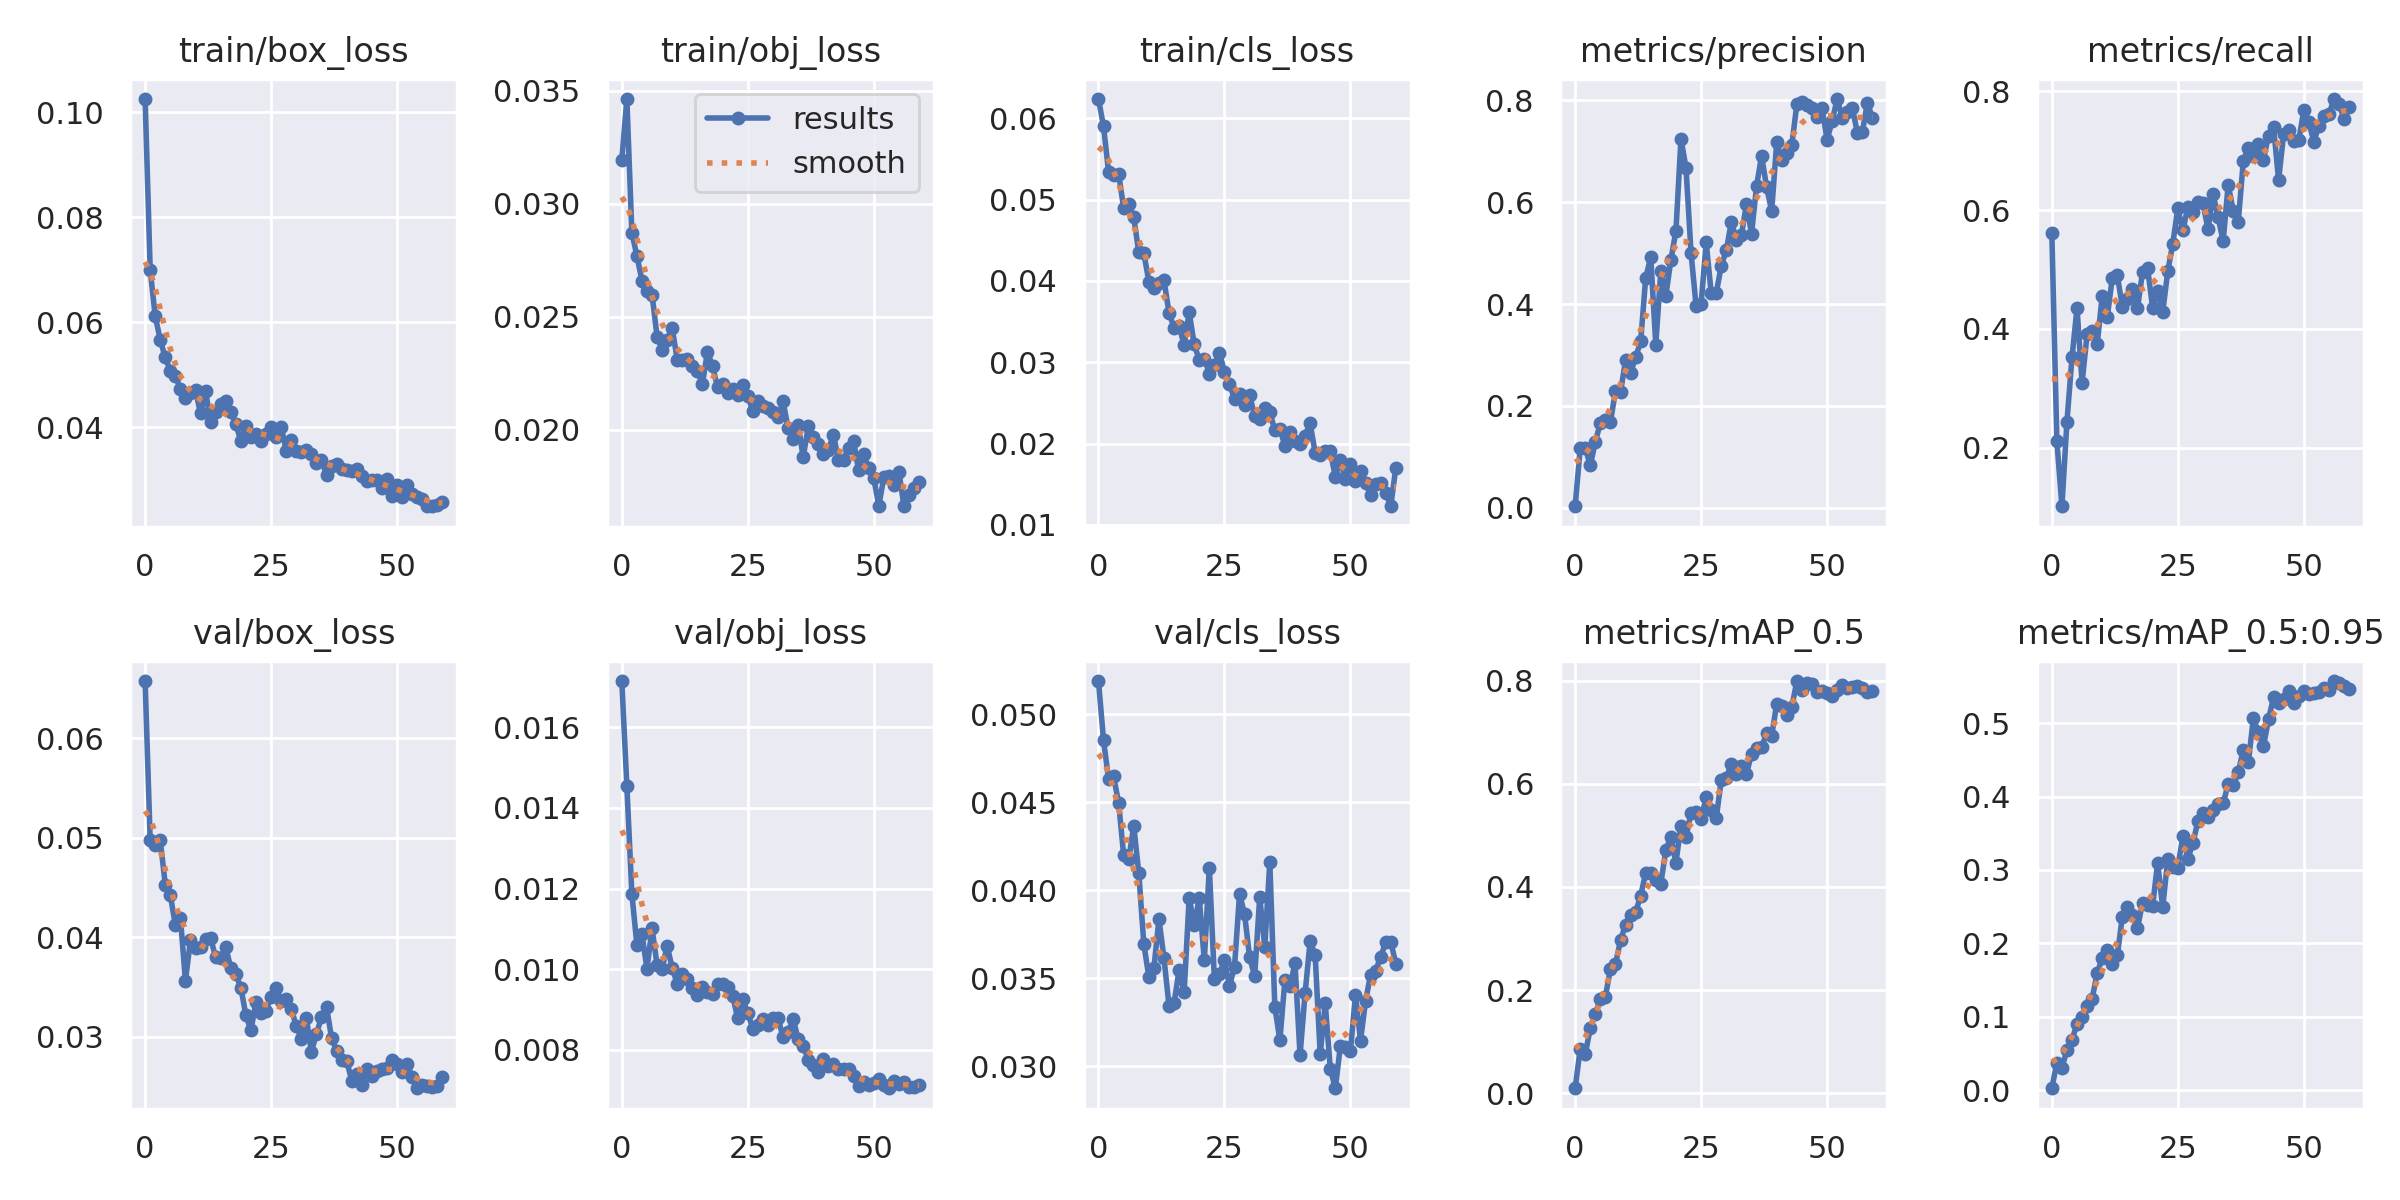

### confusion_matrix.png

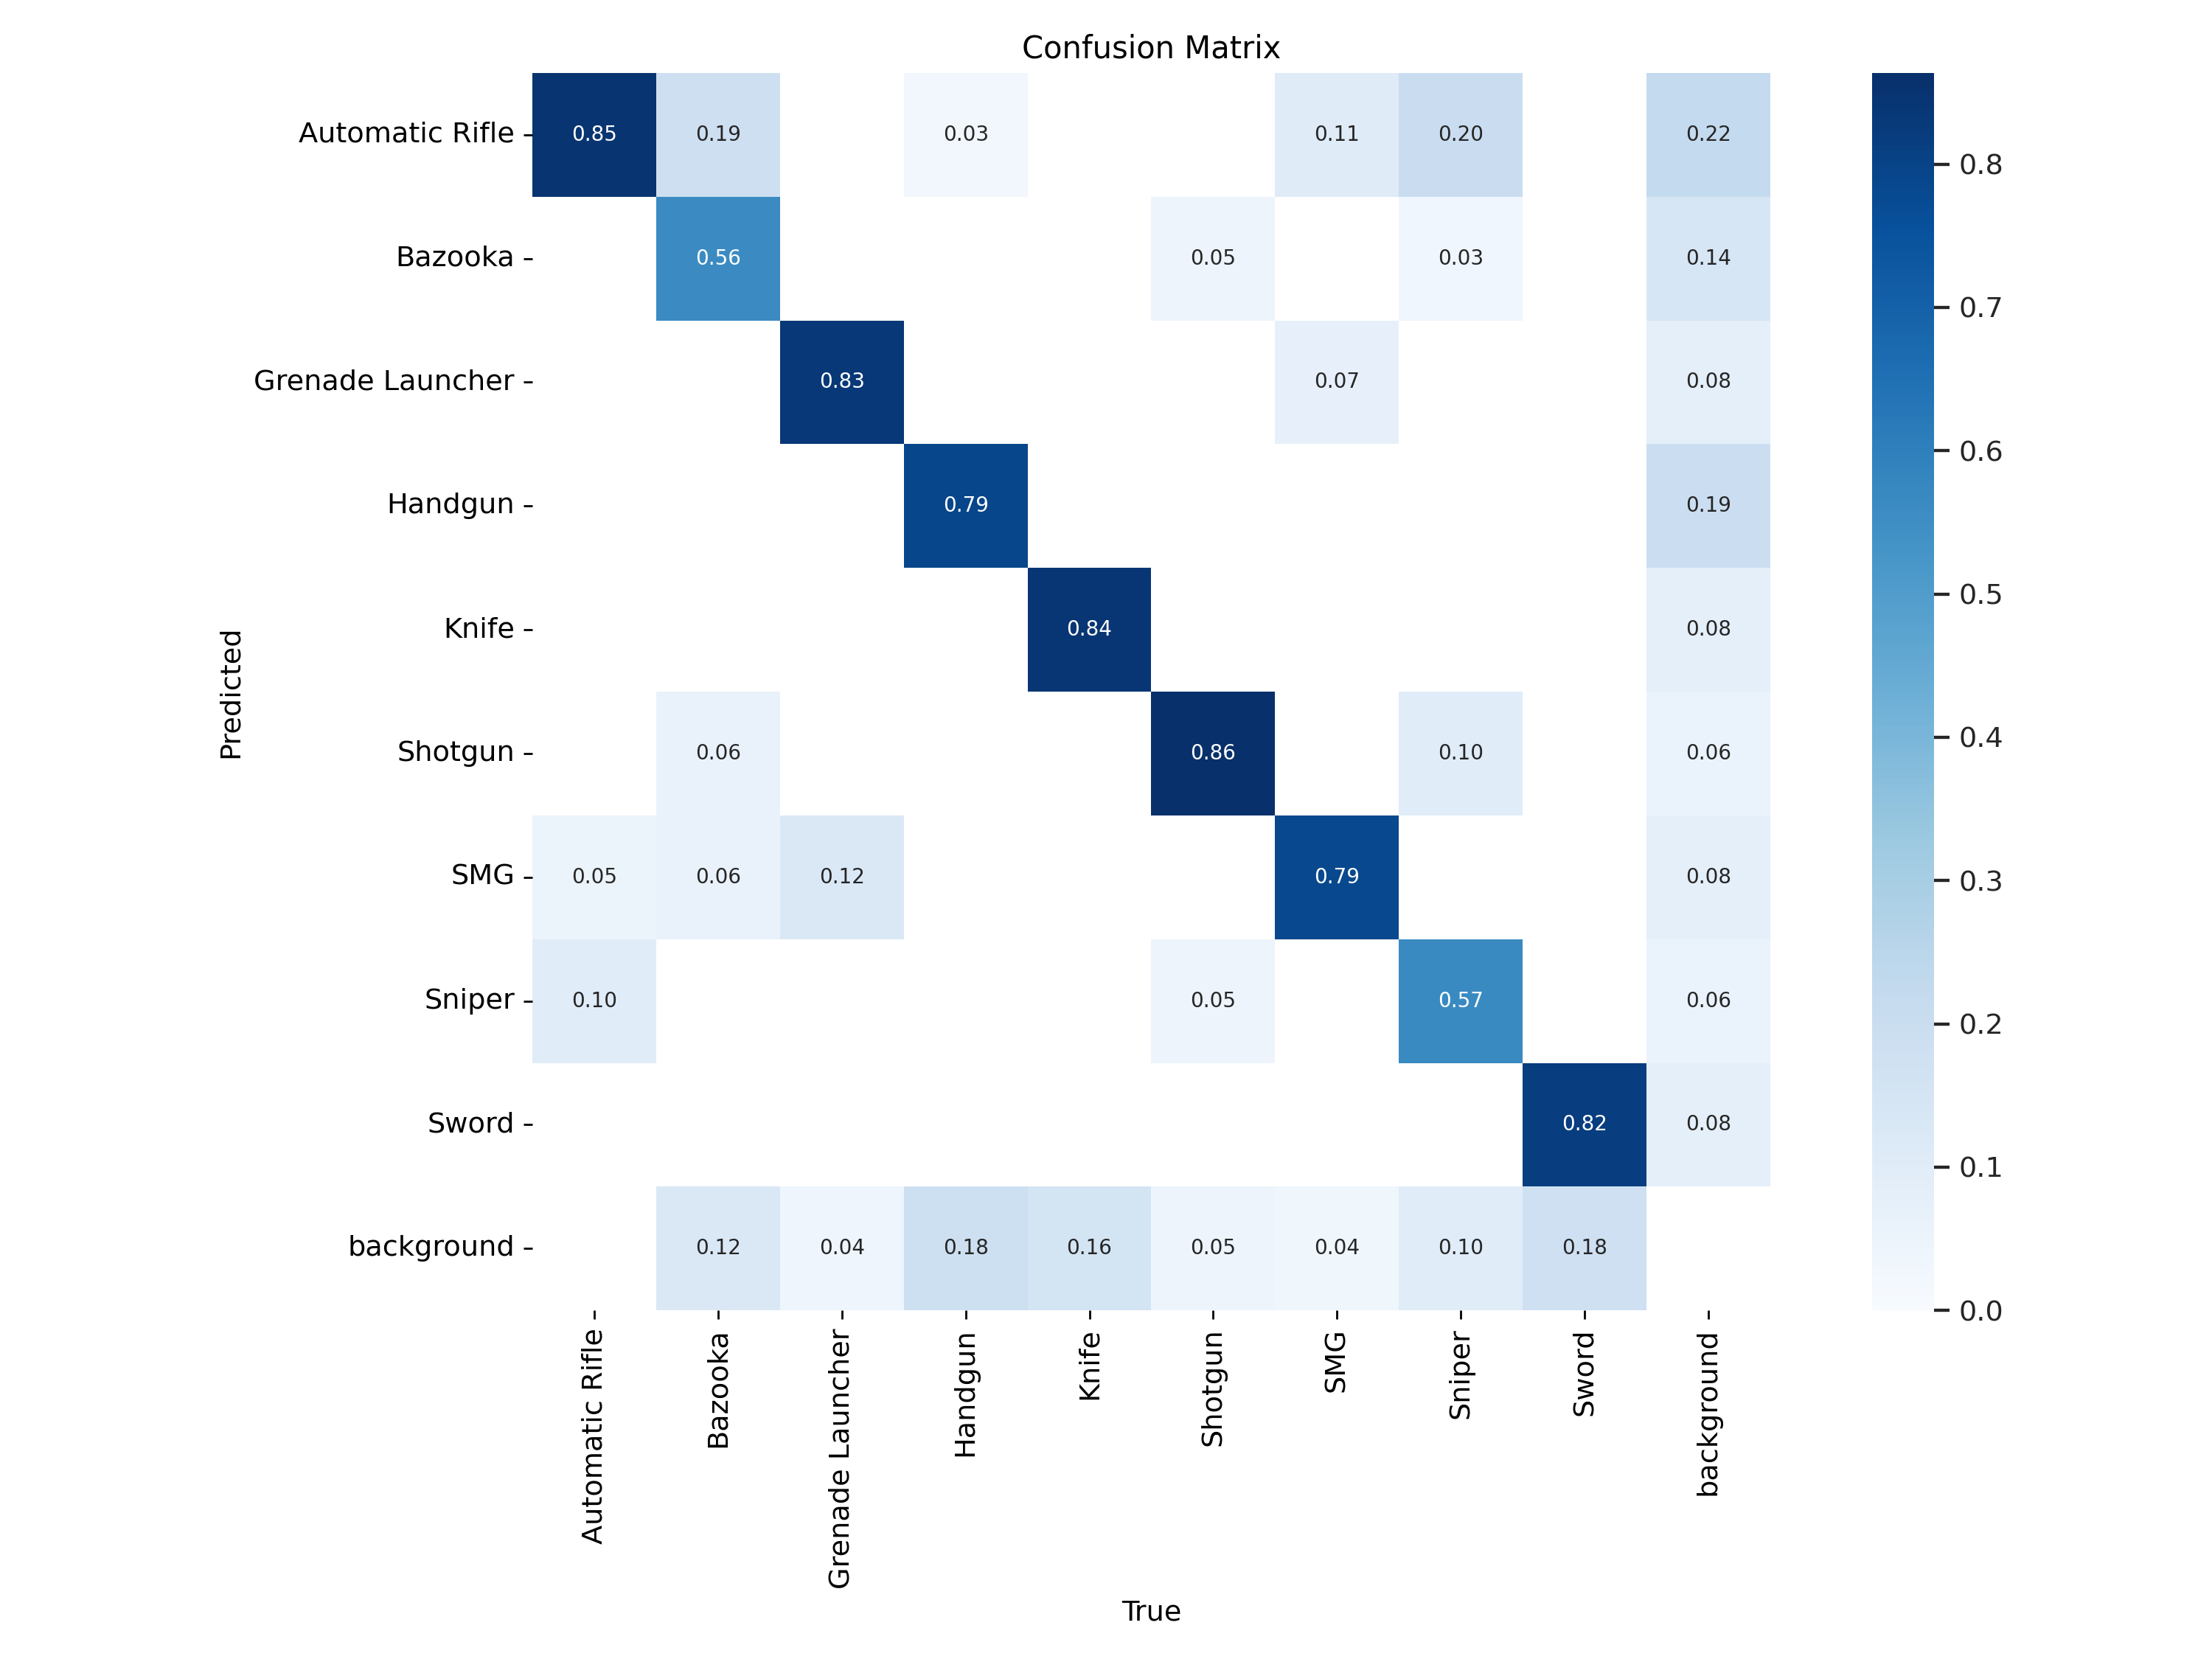

### labels.jpg

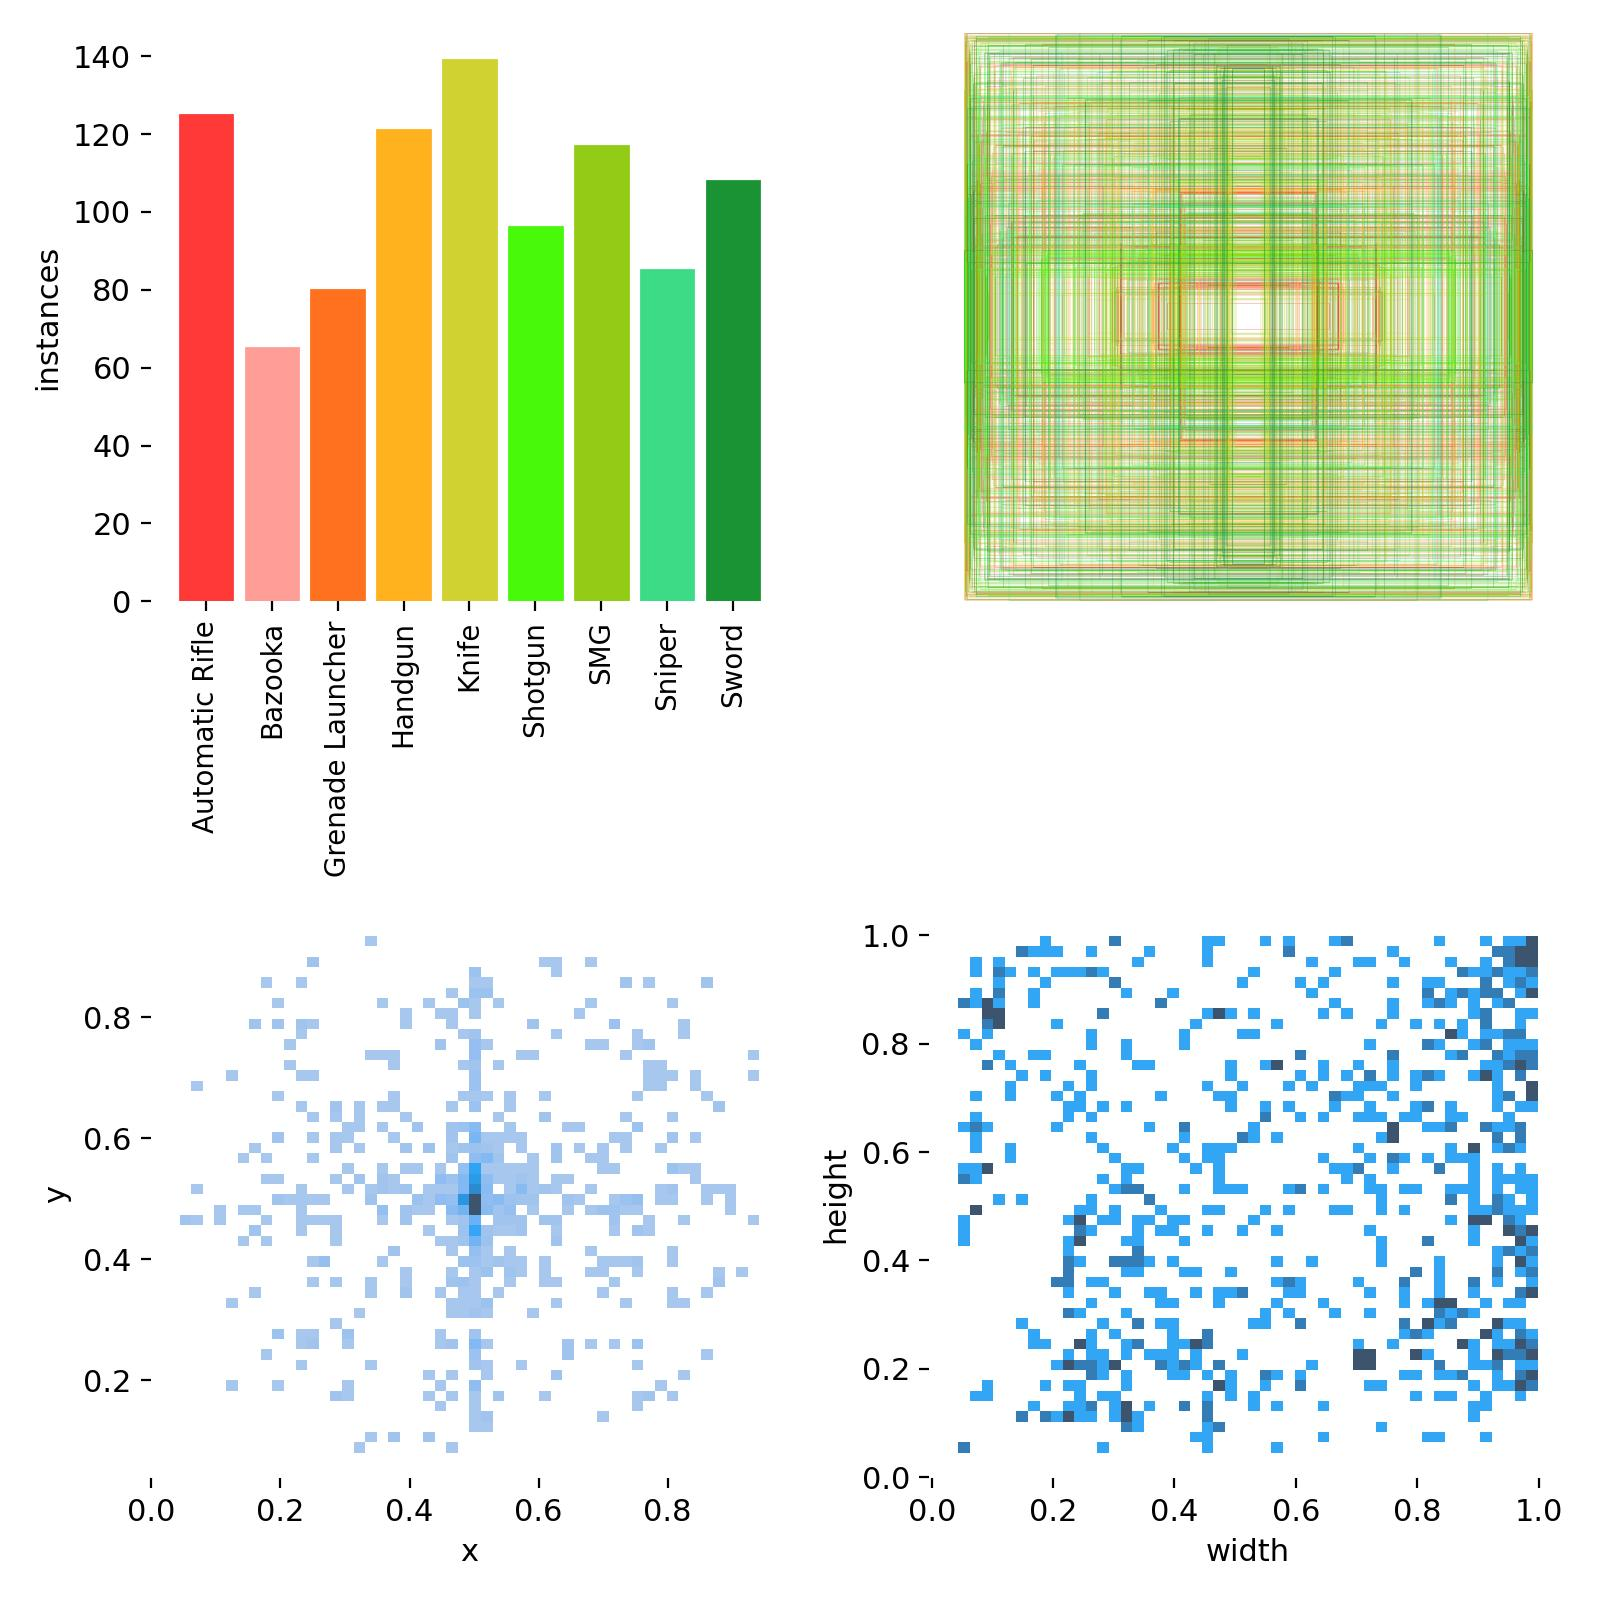

### labels_correlogram.jpg

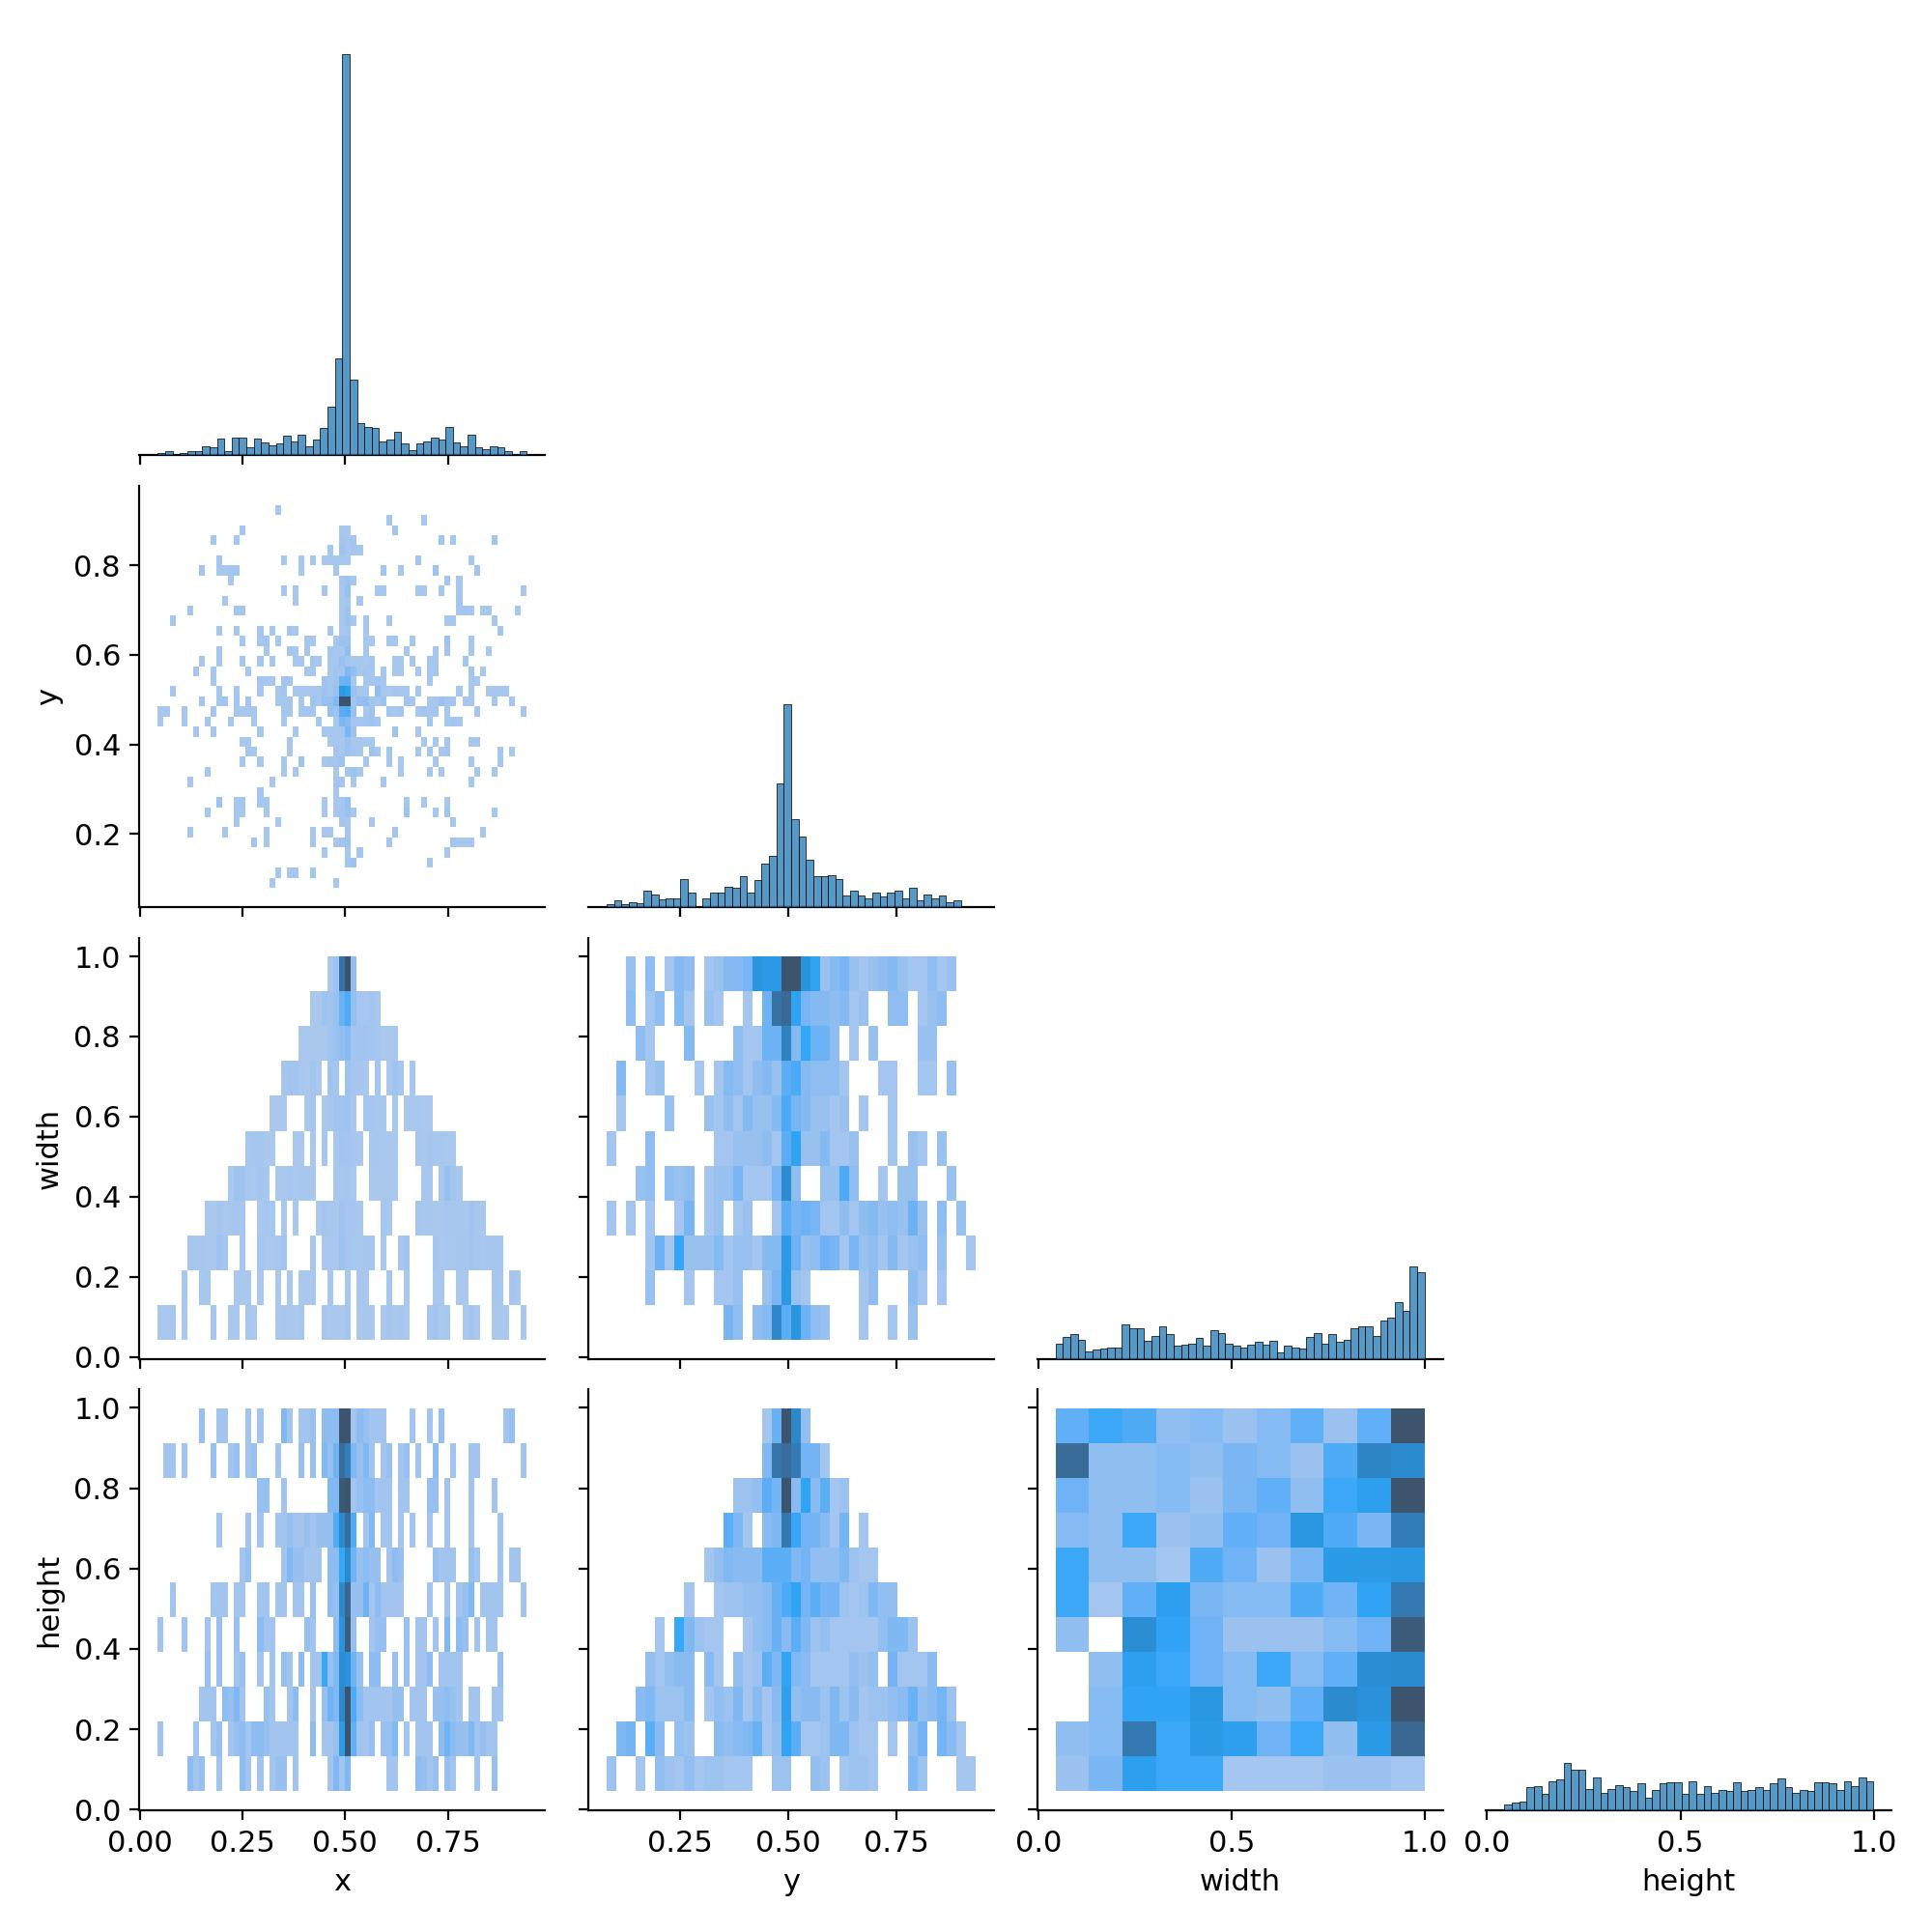

### train_results/train_batch0.jpg

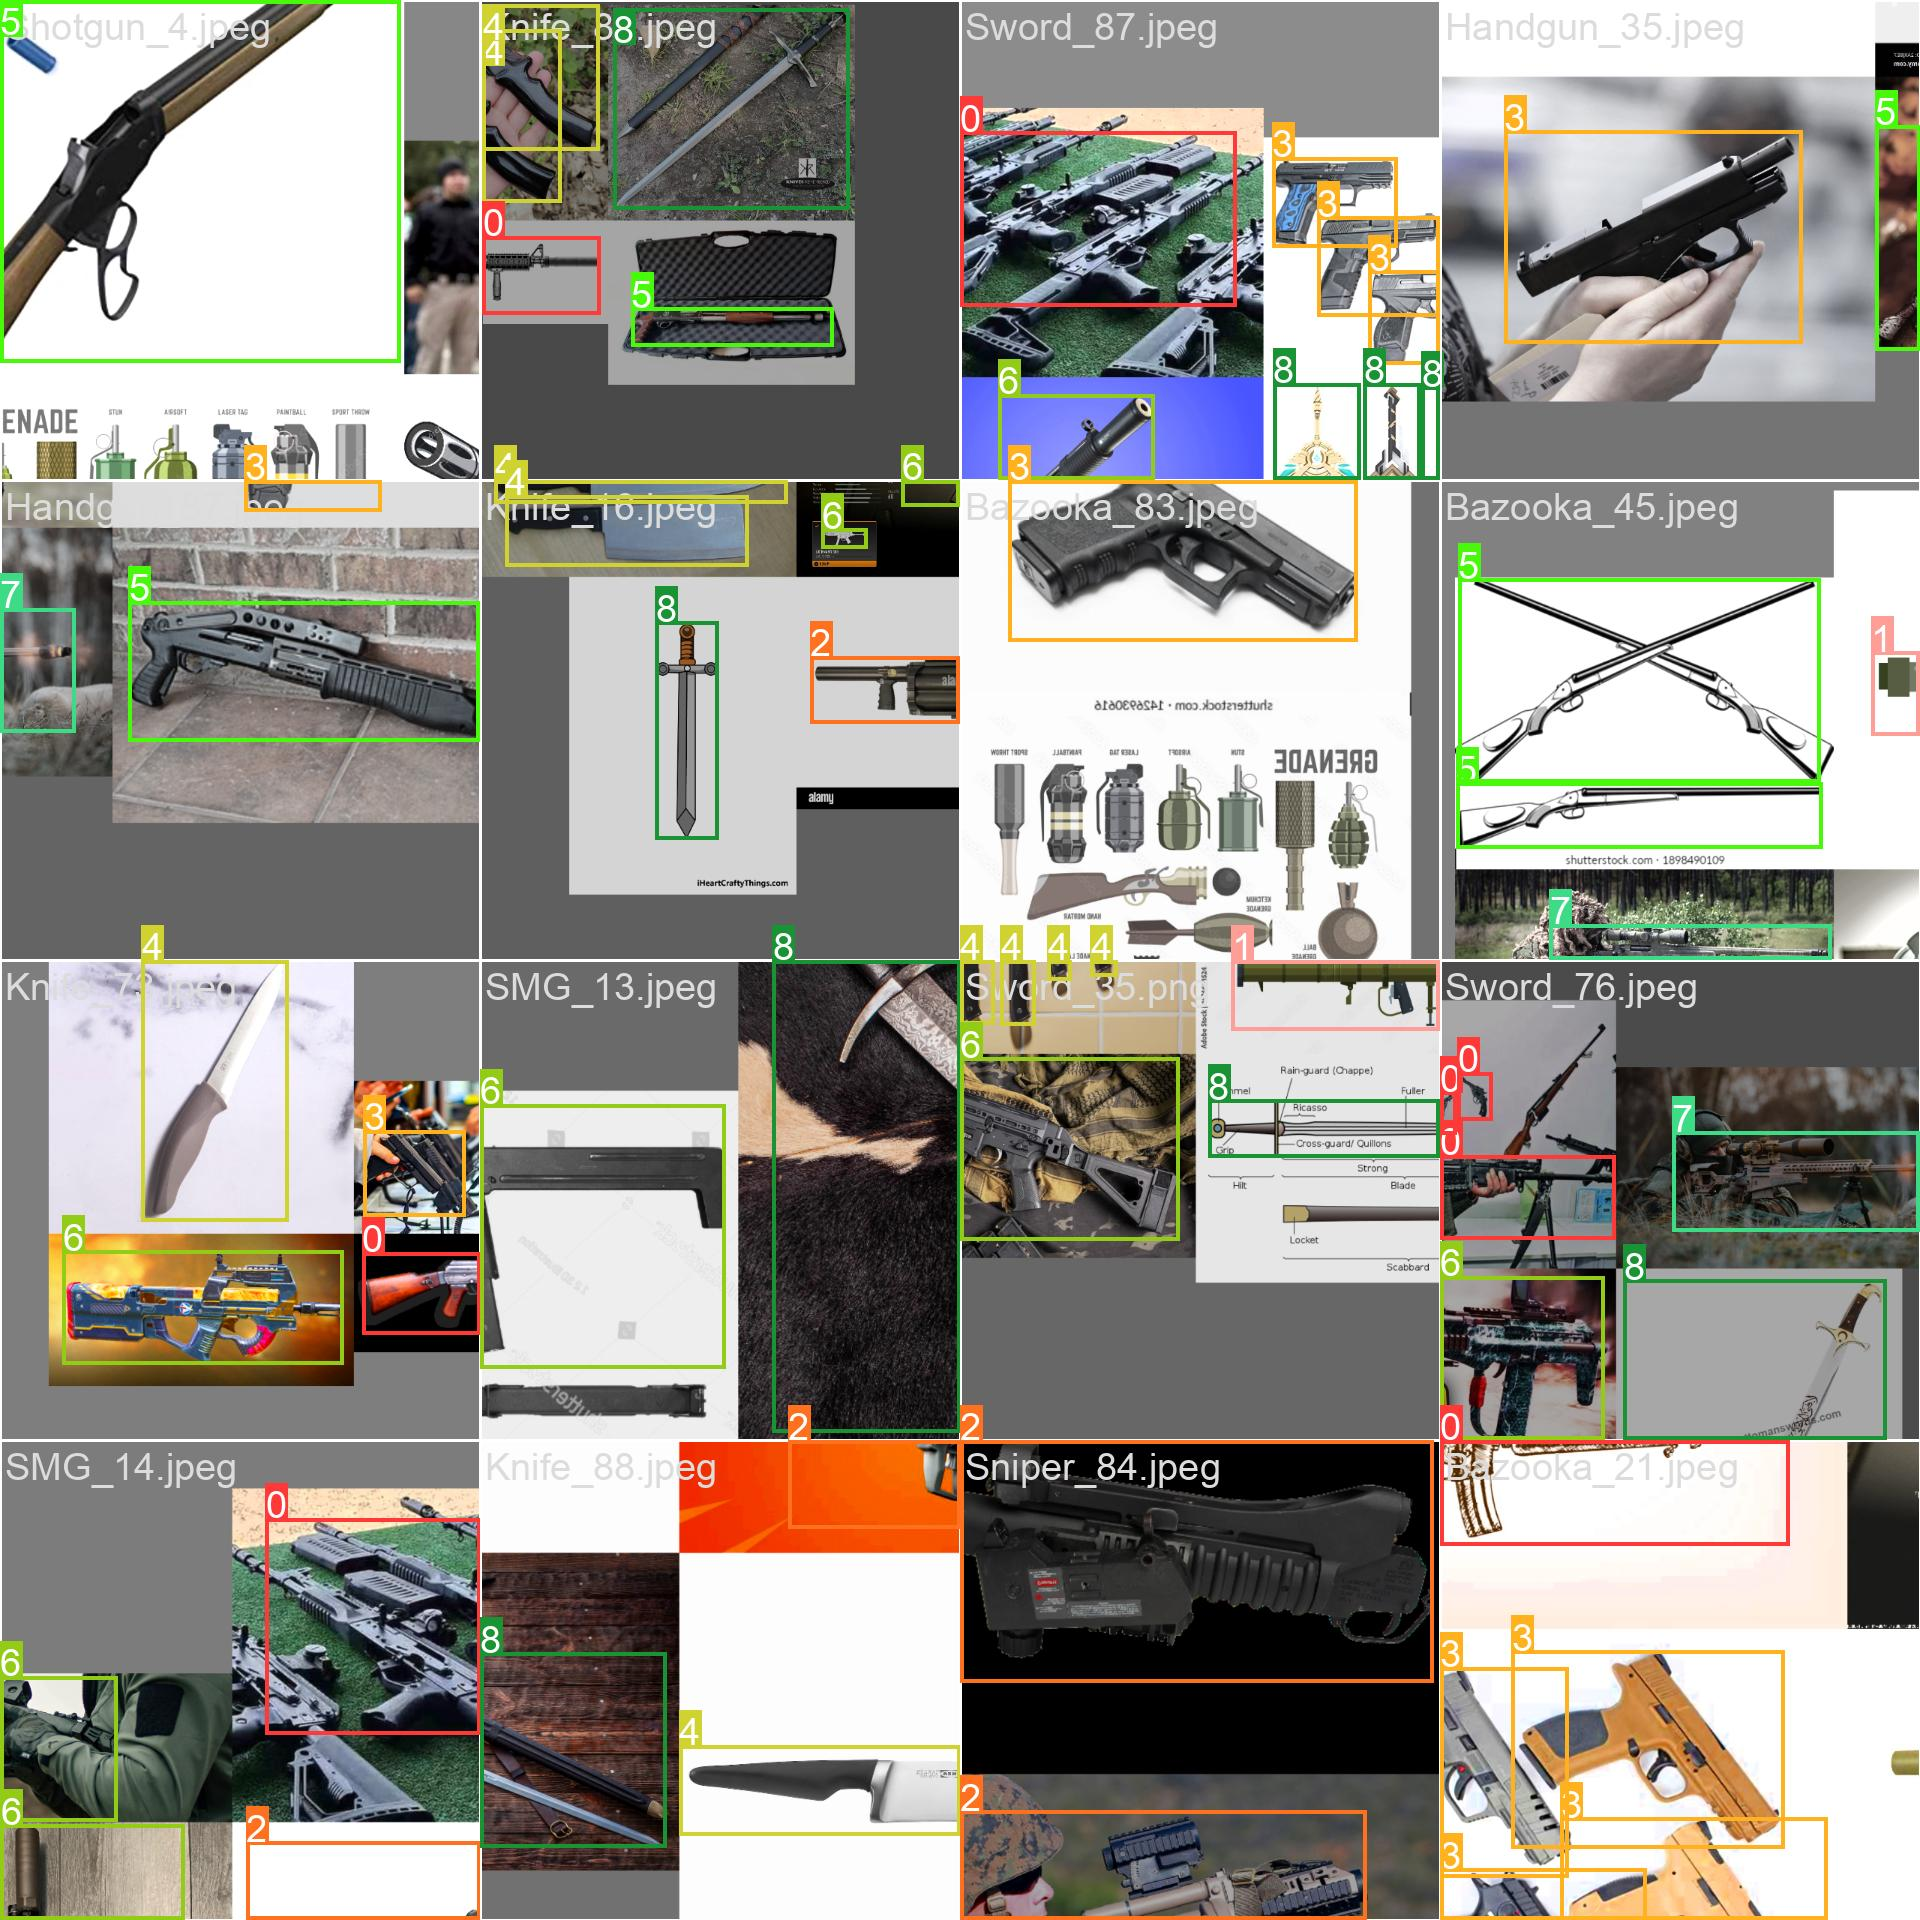

### train_results/val_batch0_pred.jpg

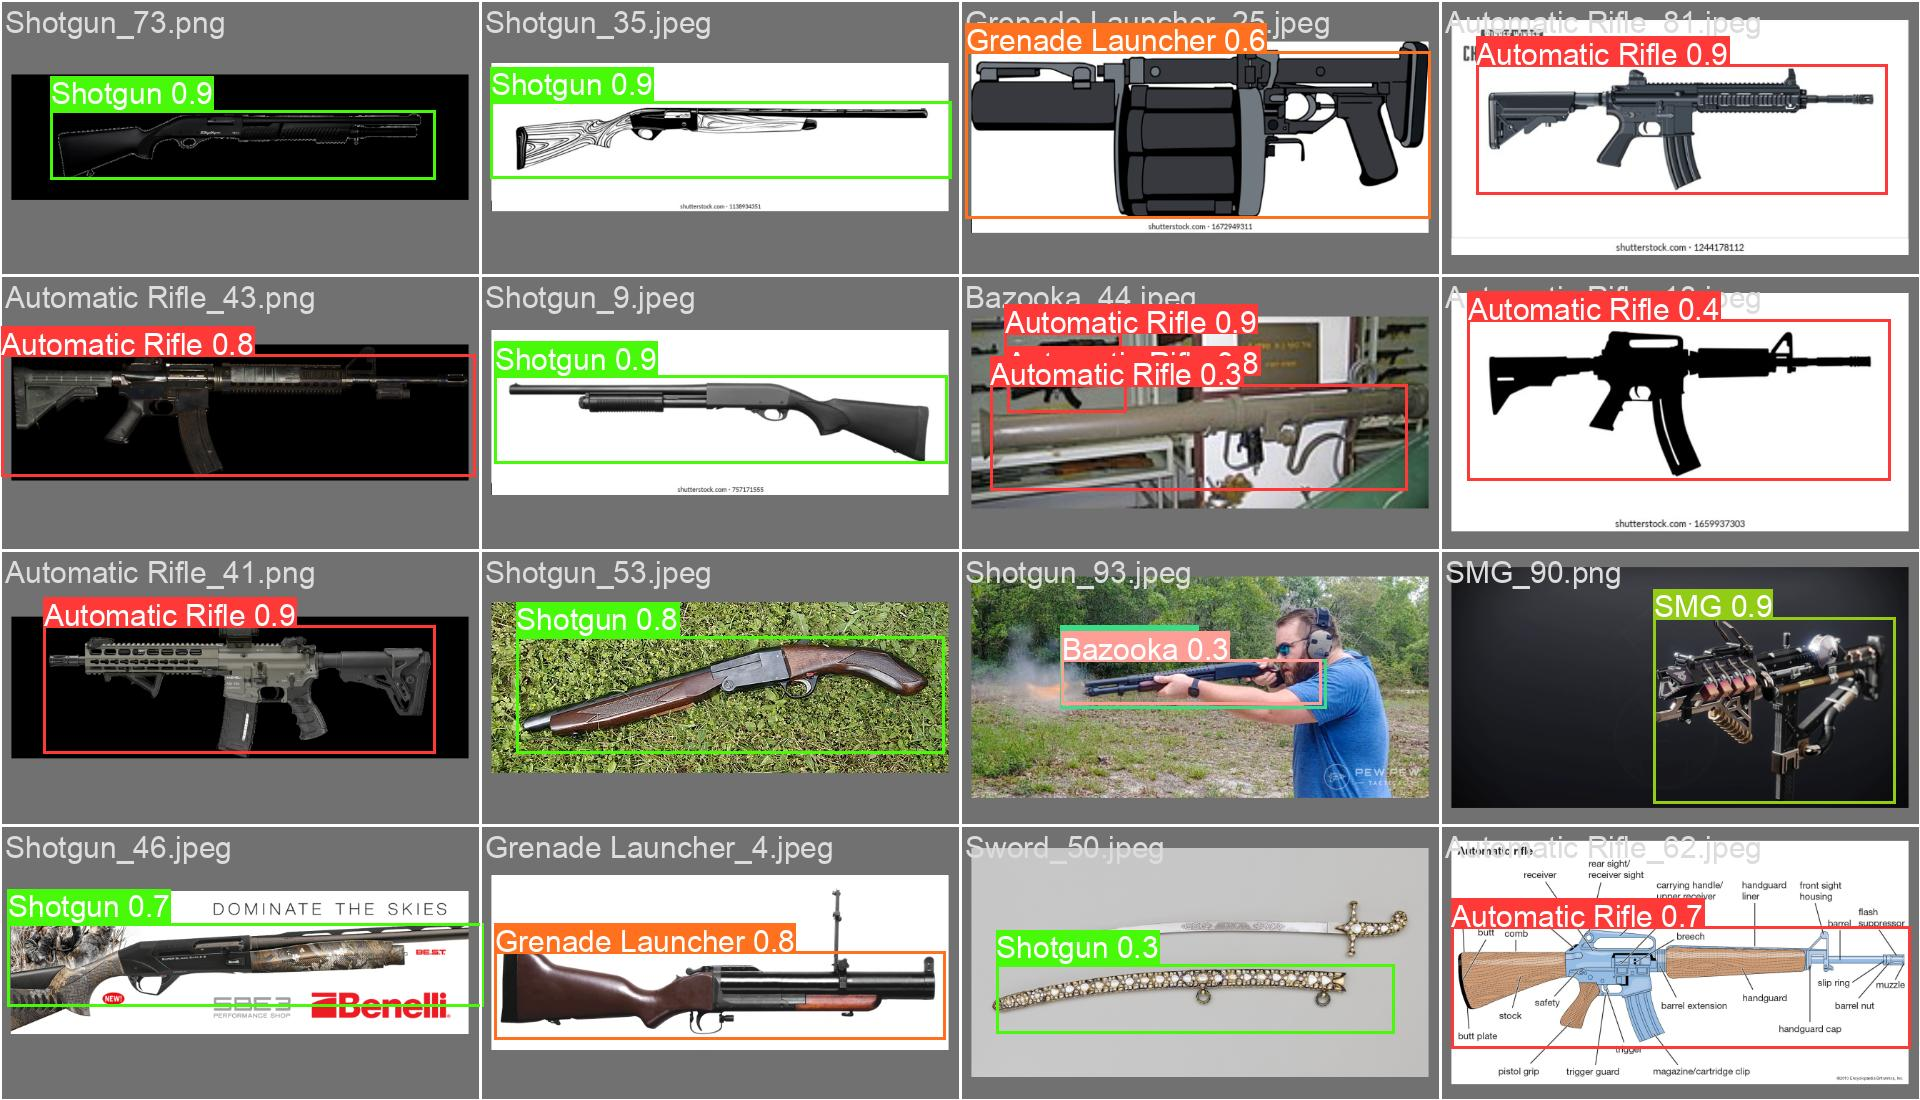

### train_results/R_curve.png

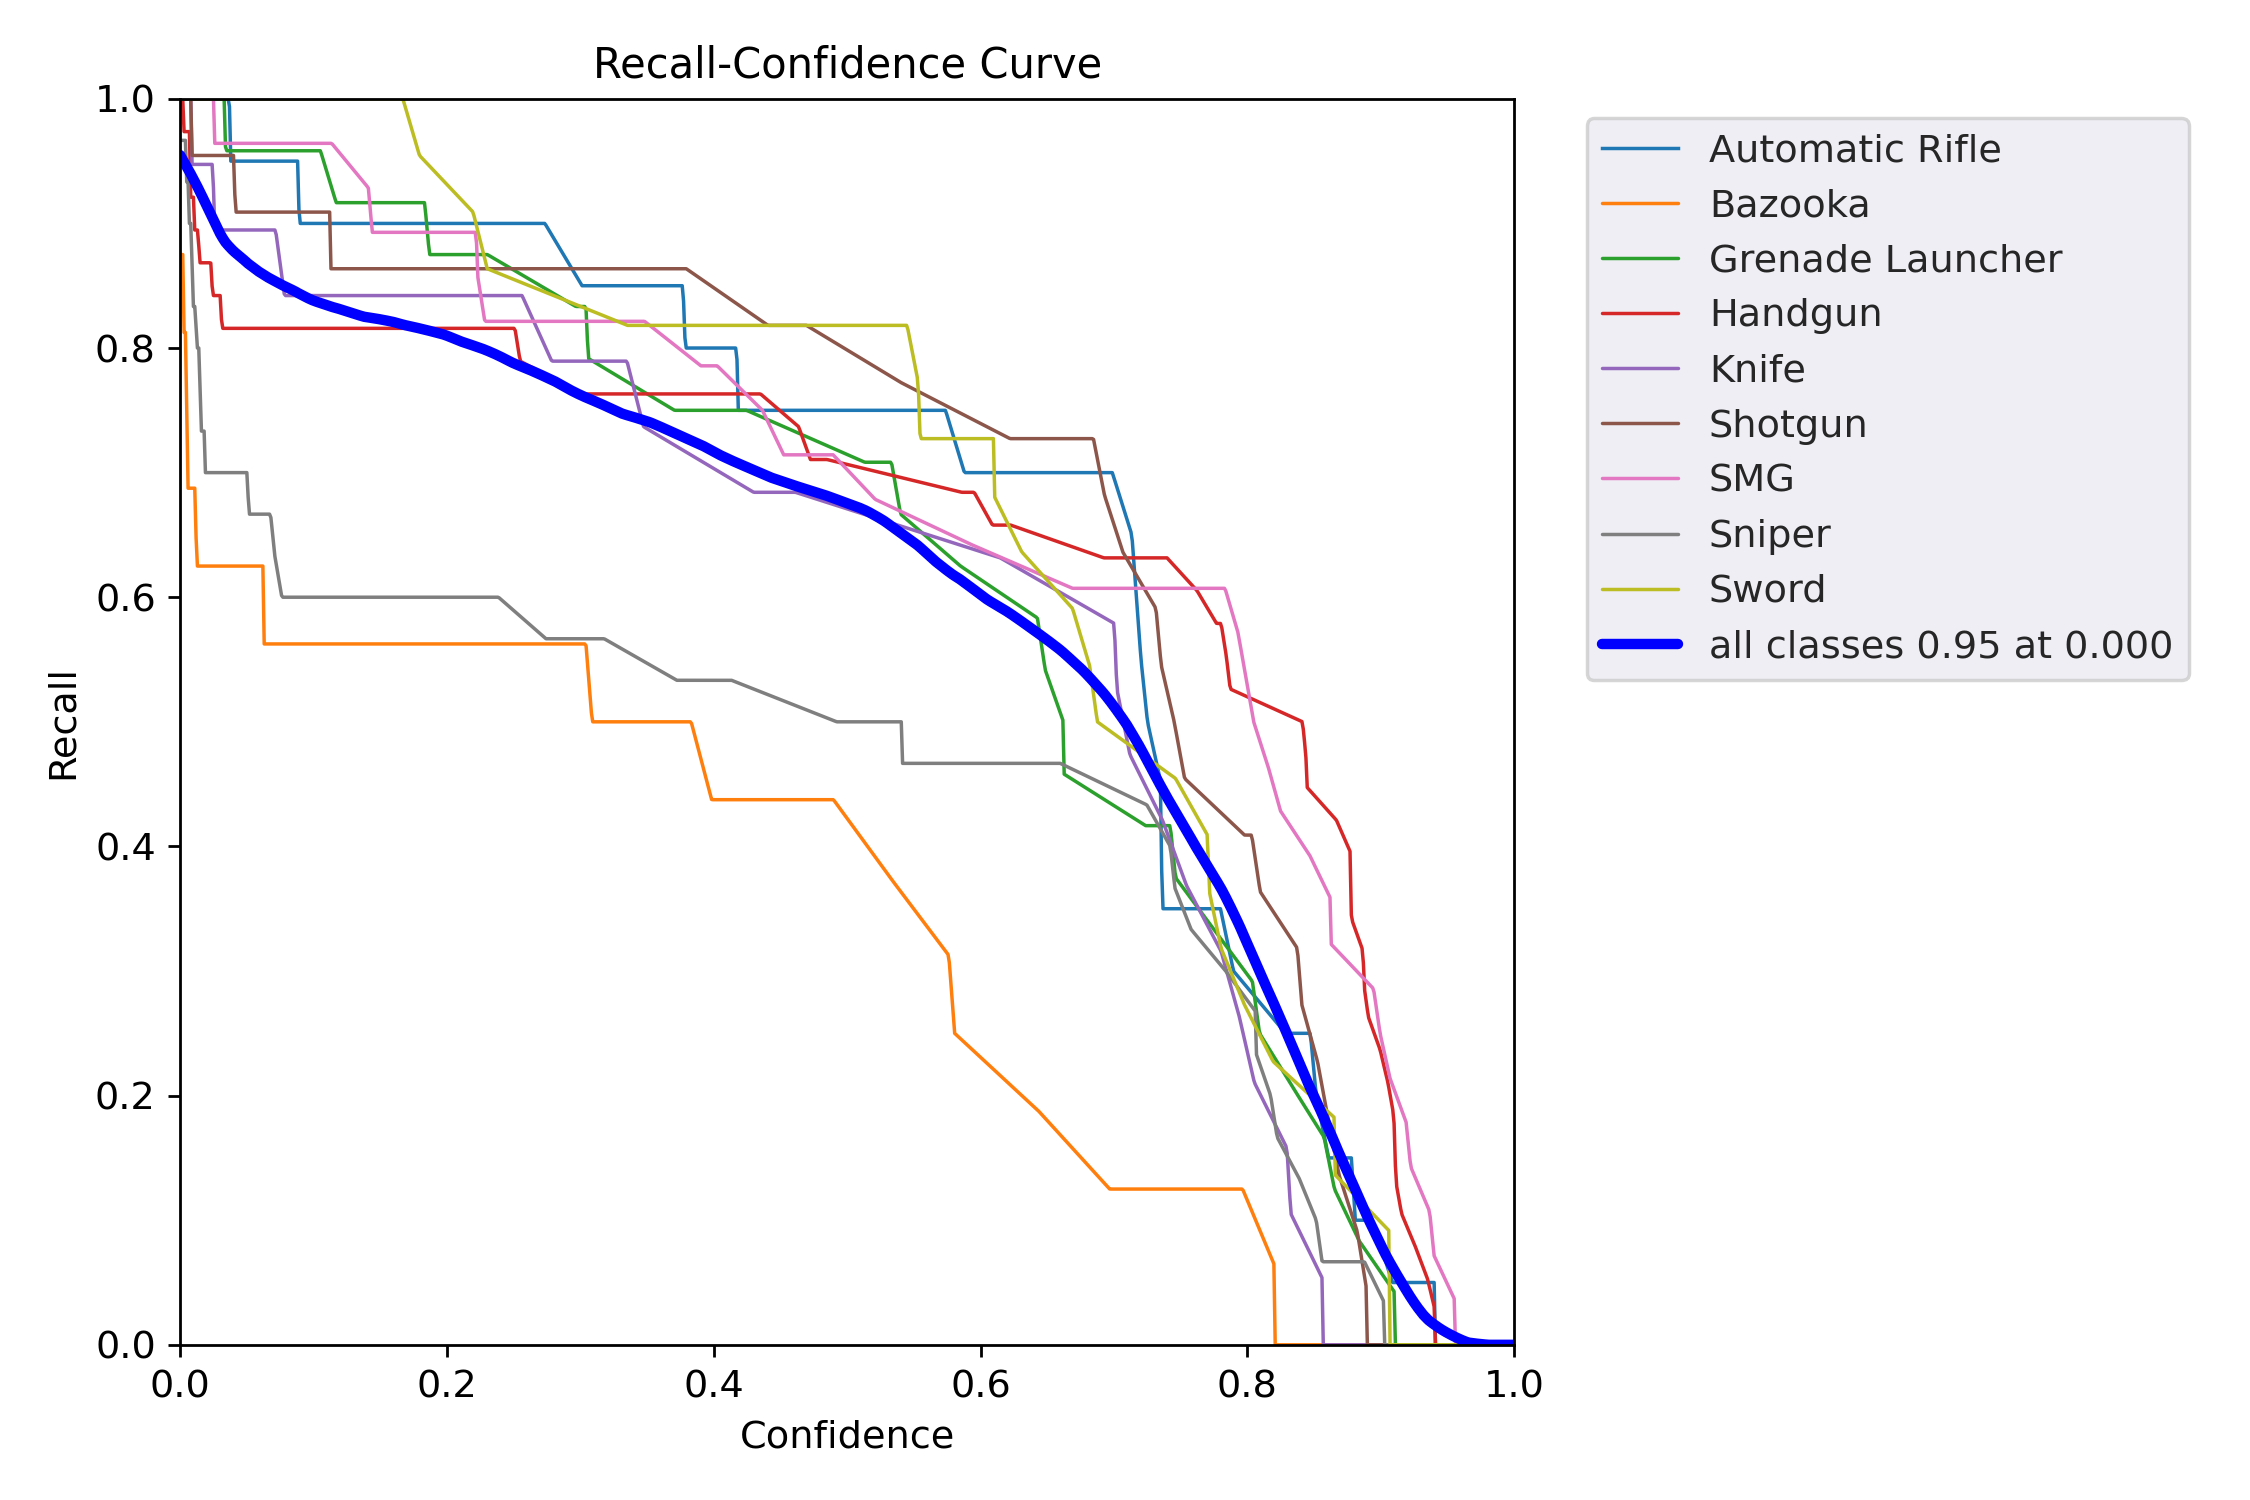

### train_results/val_batch0_labels.jpg

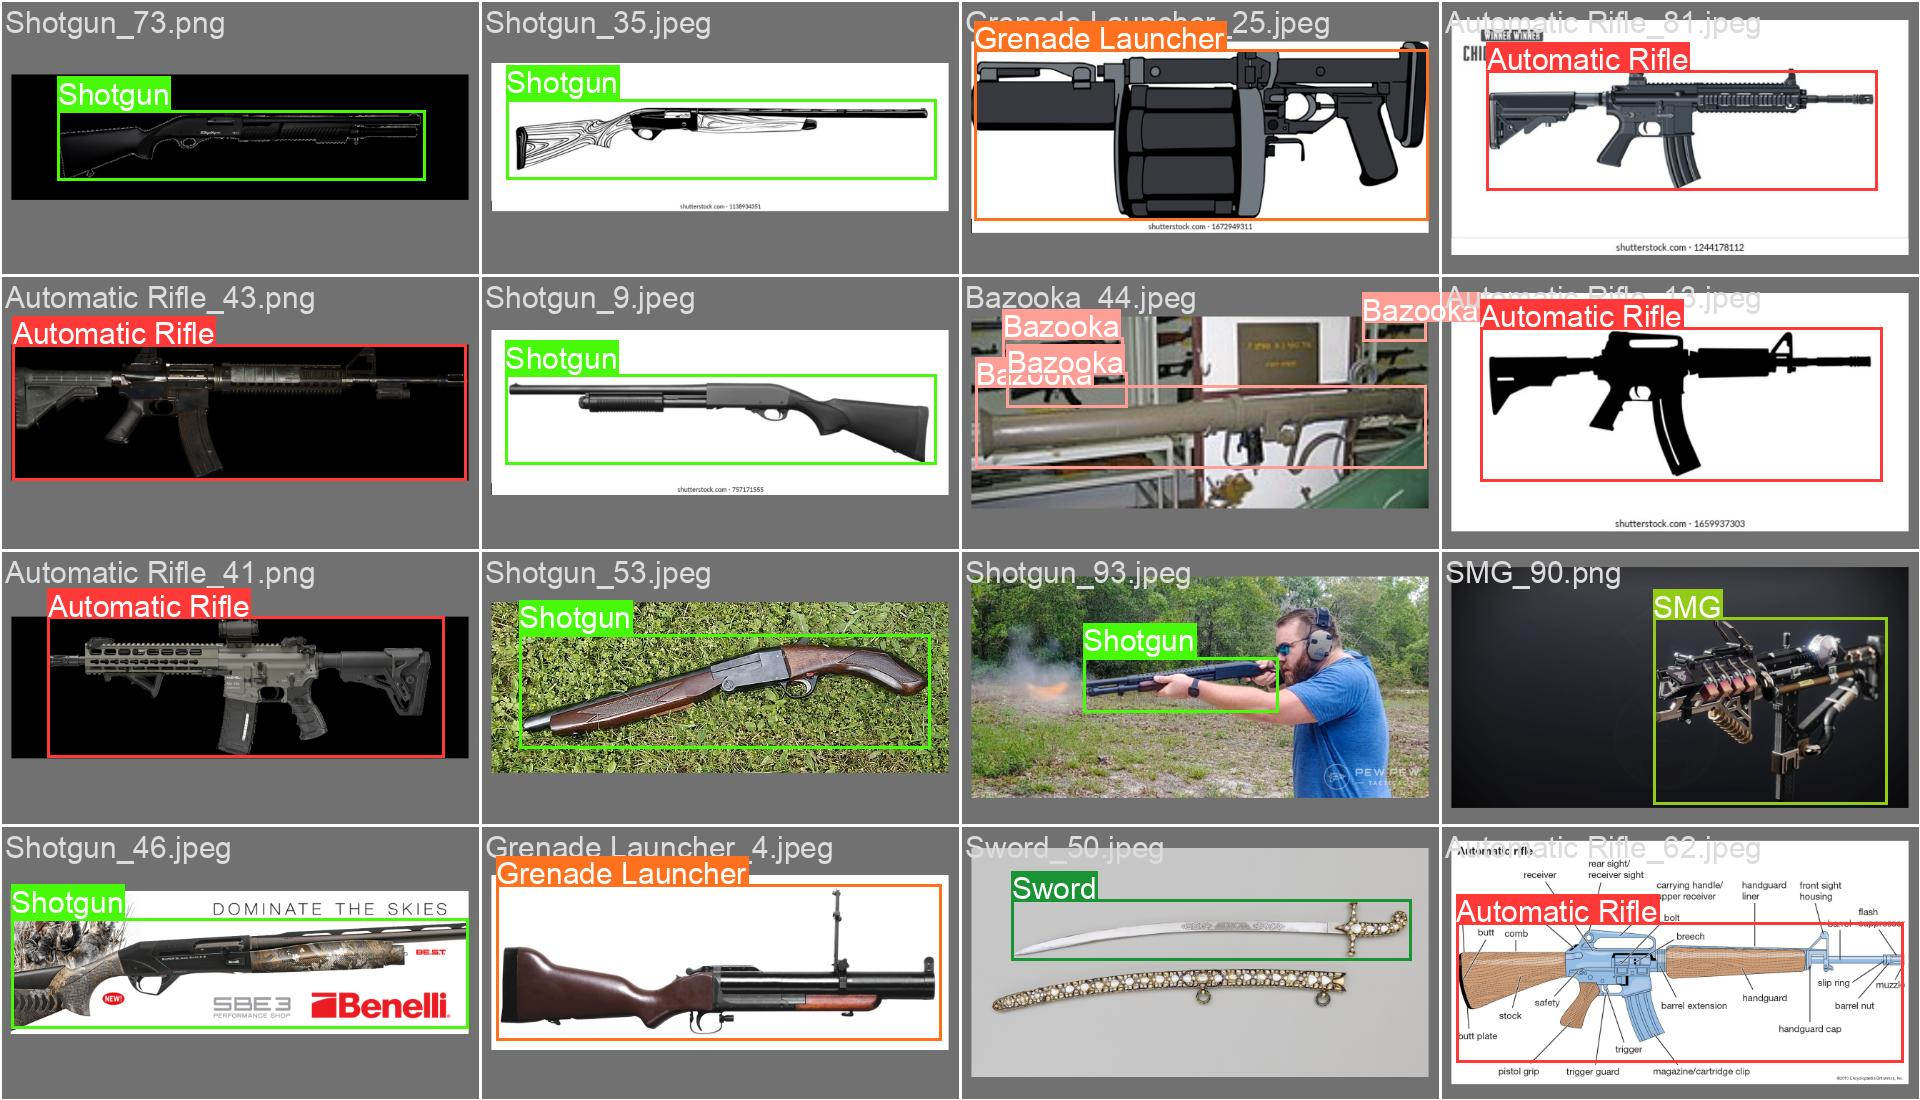

### train_results/train_batch1.jpg

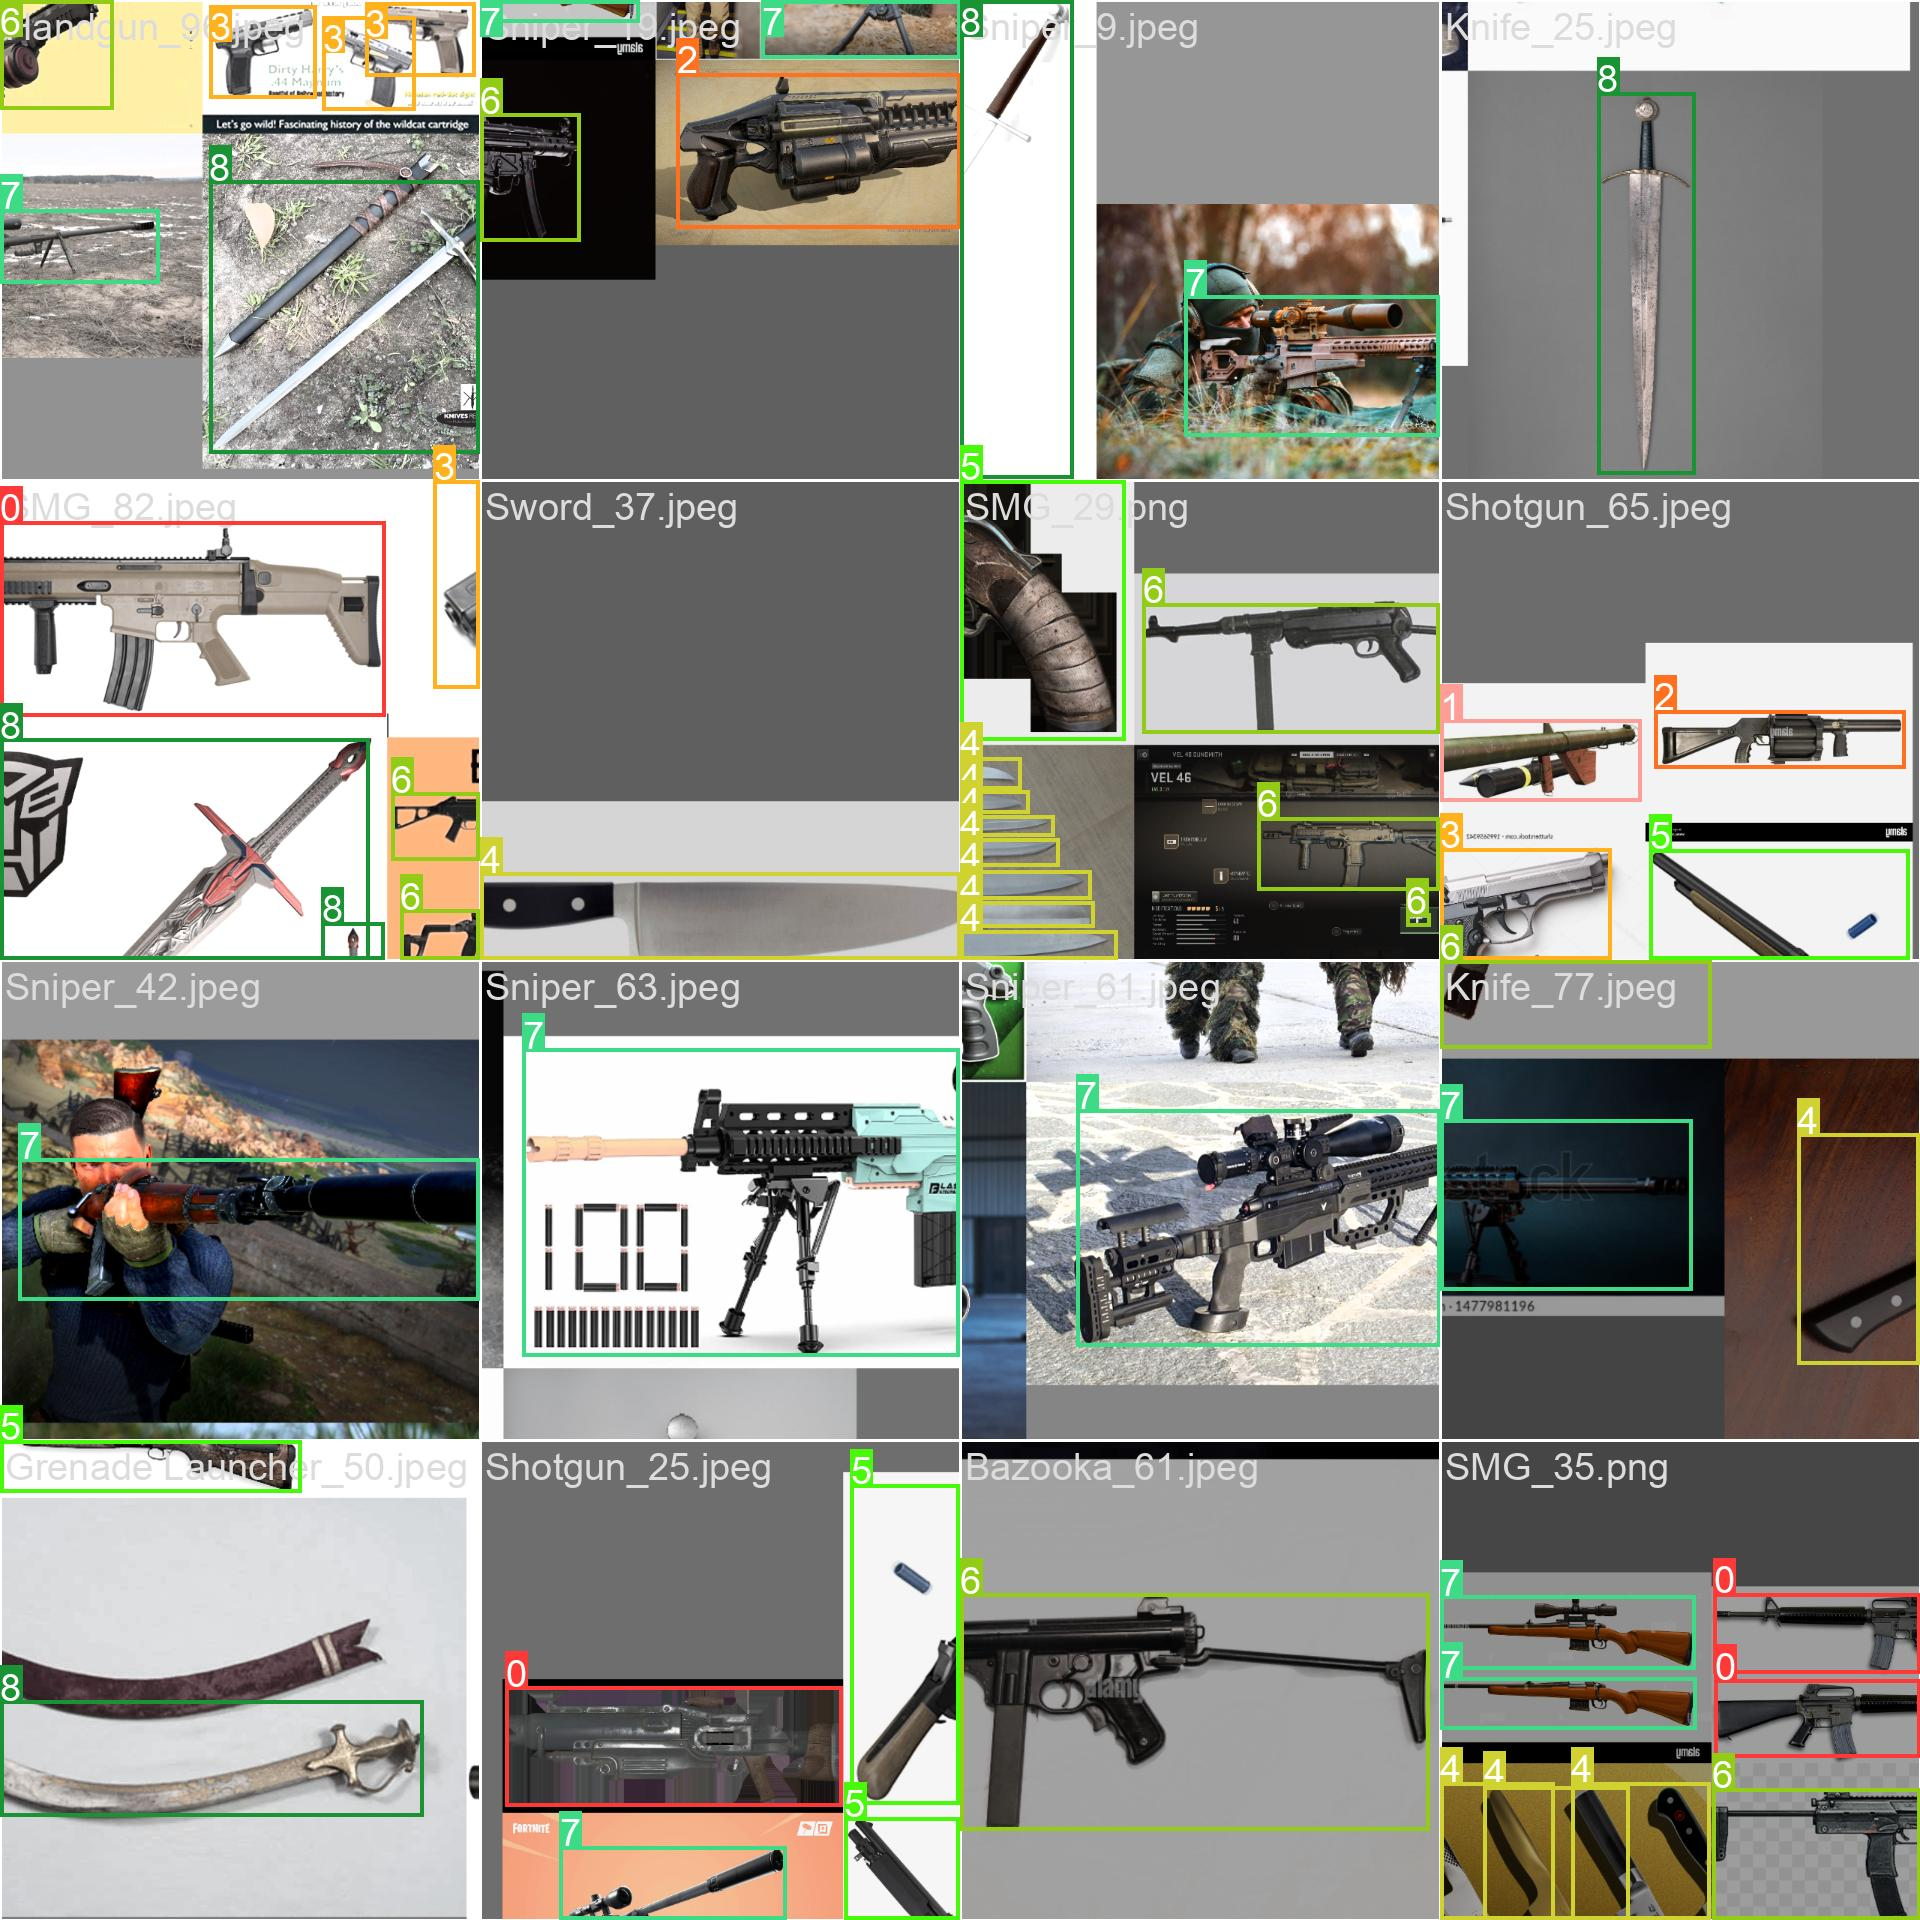

### train_results/val_batch2_pred.jpg

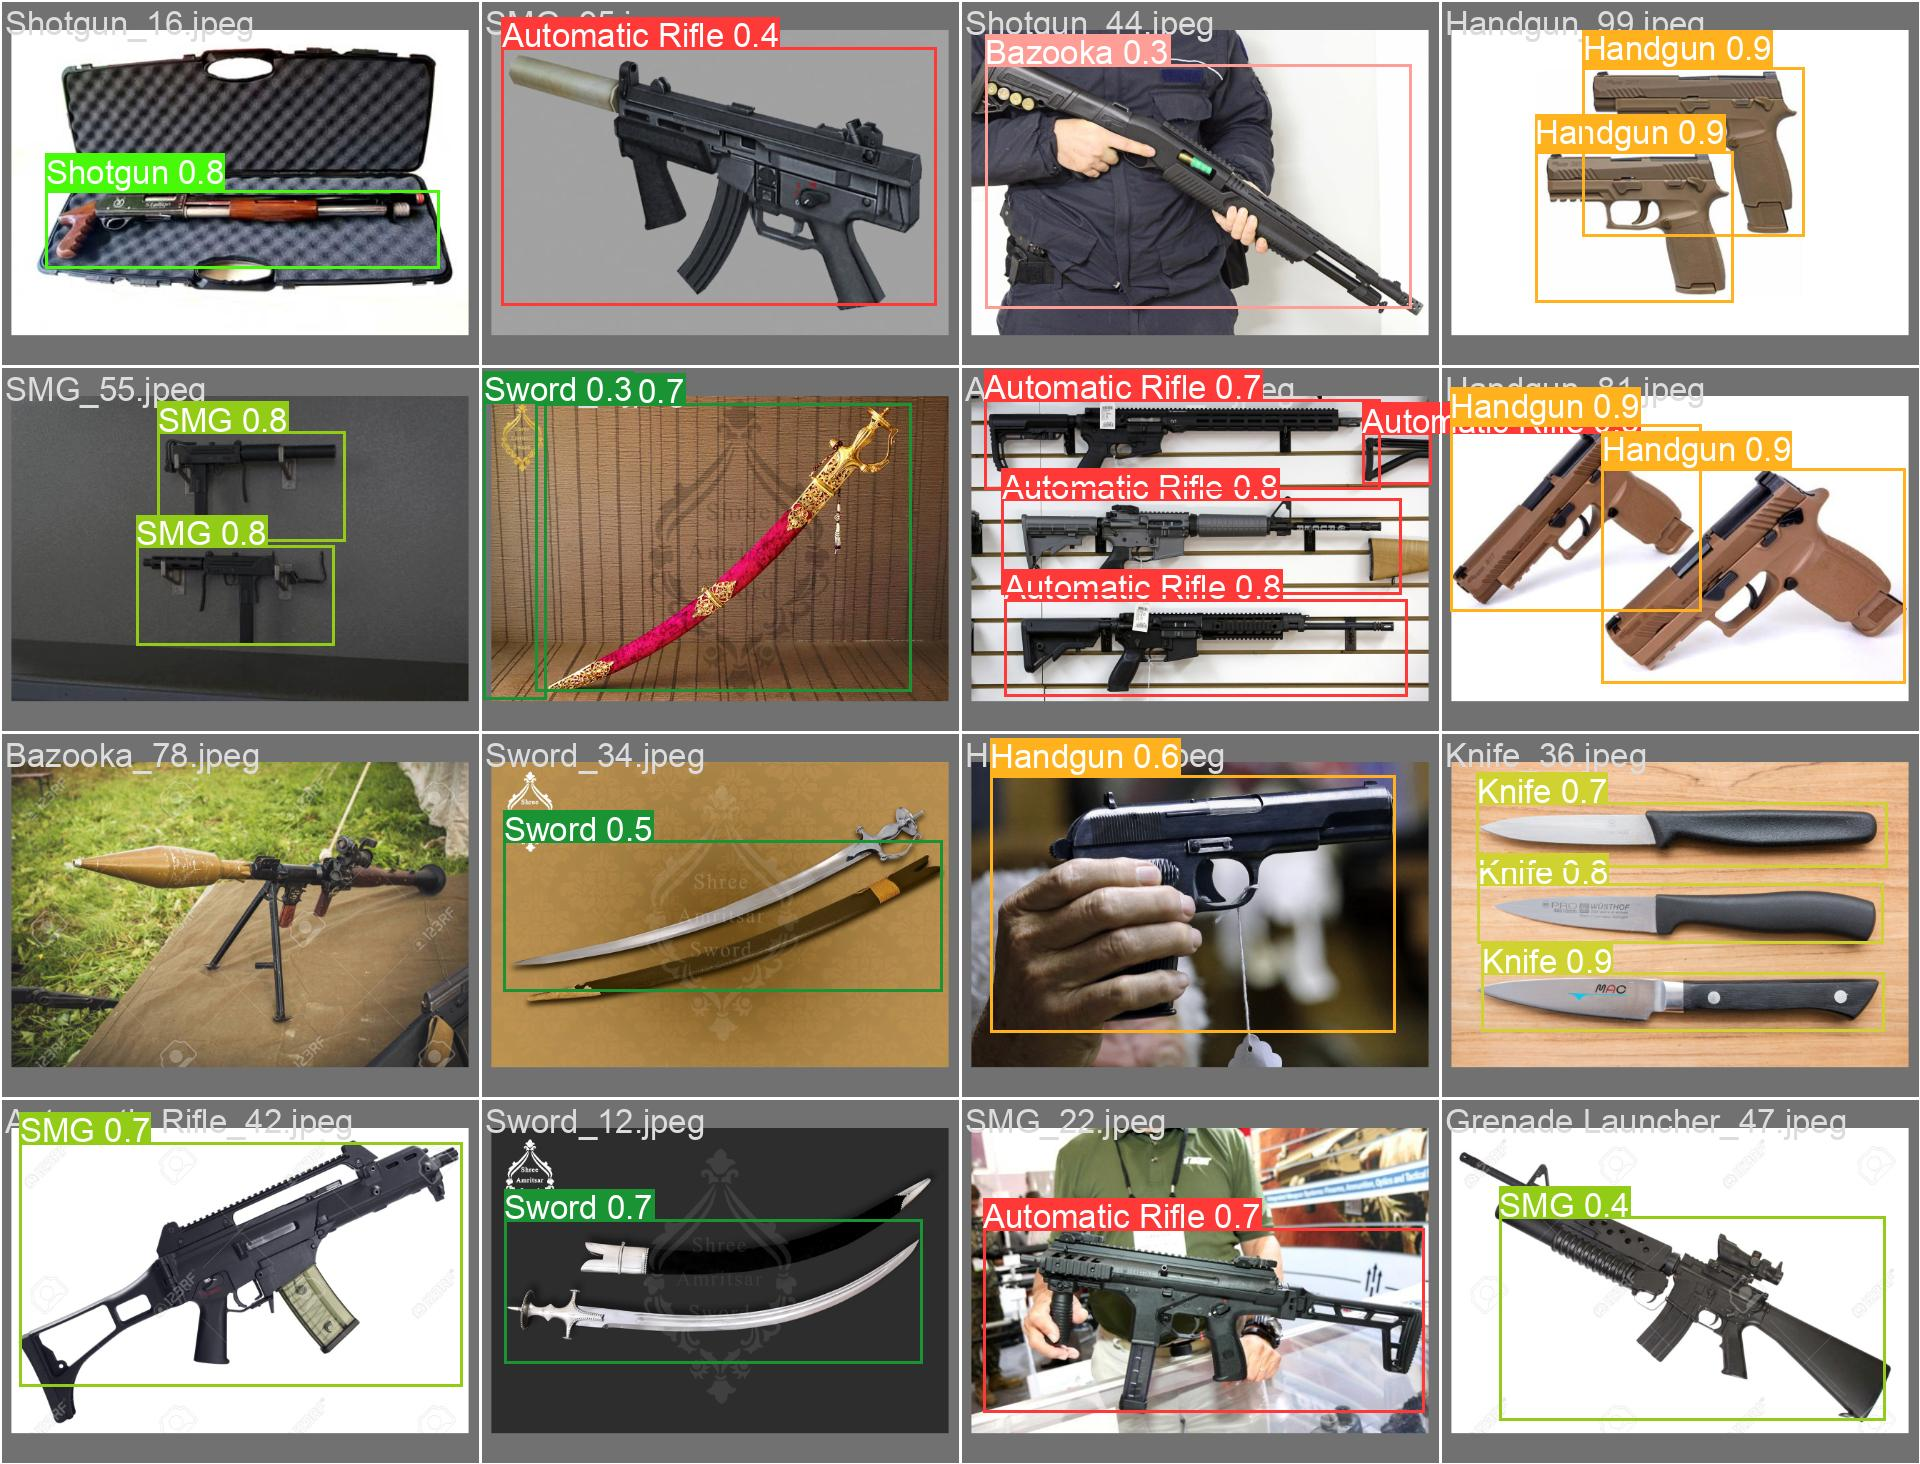

### train_results/train_batch2.jpg

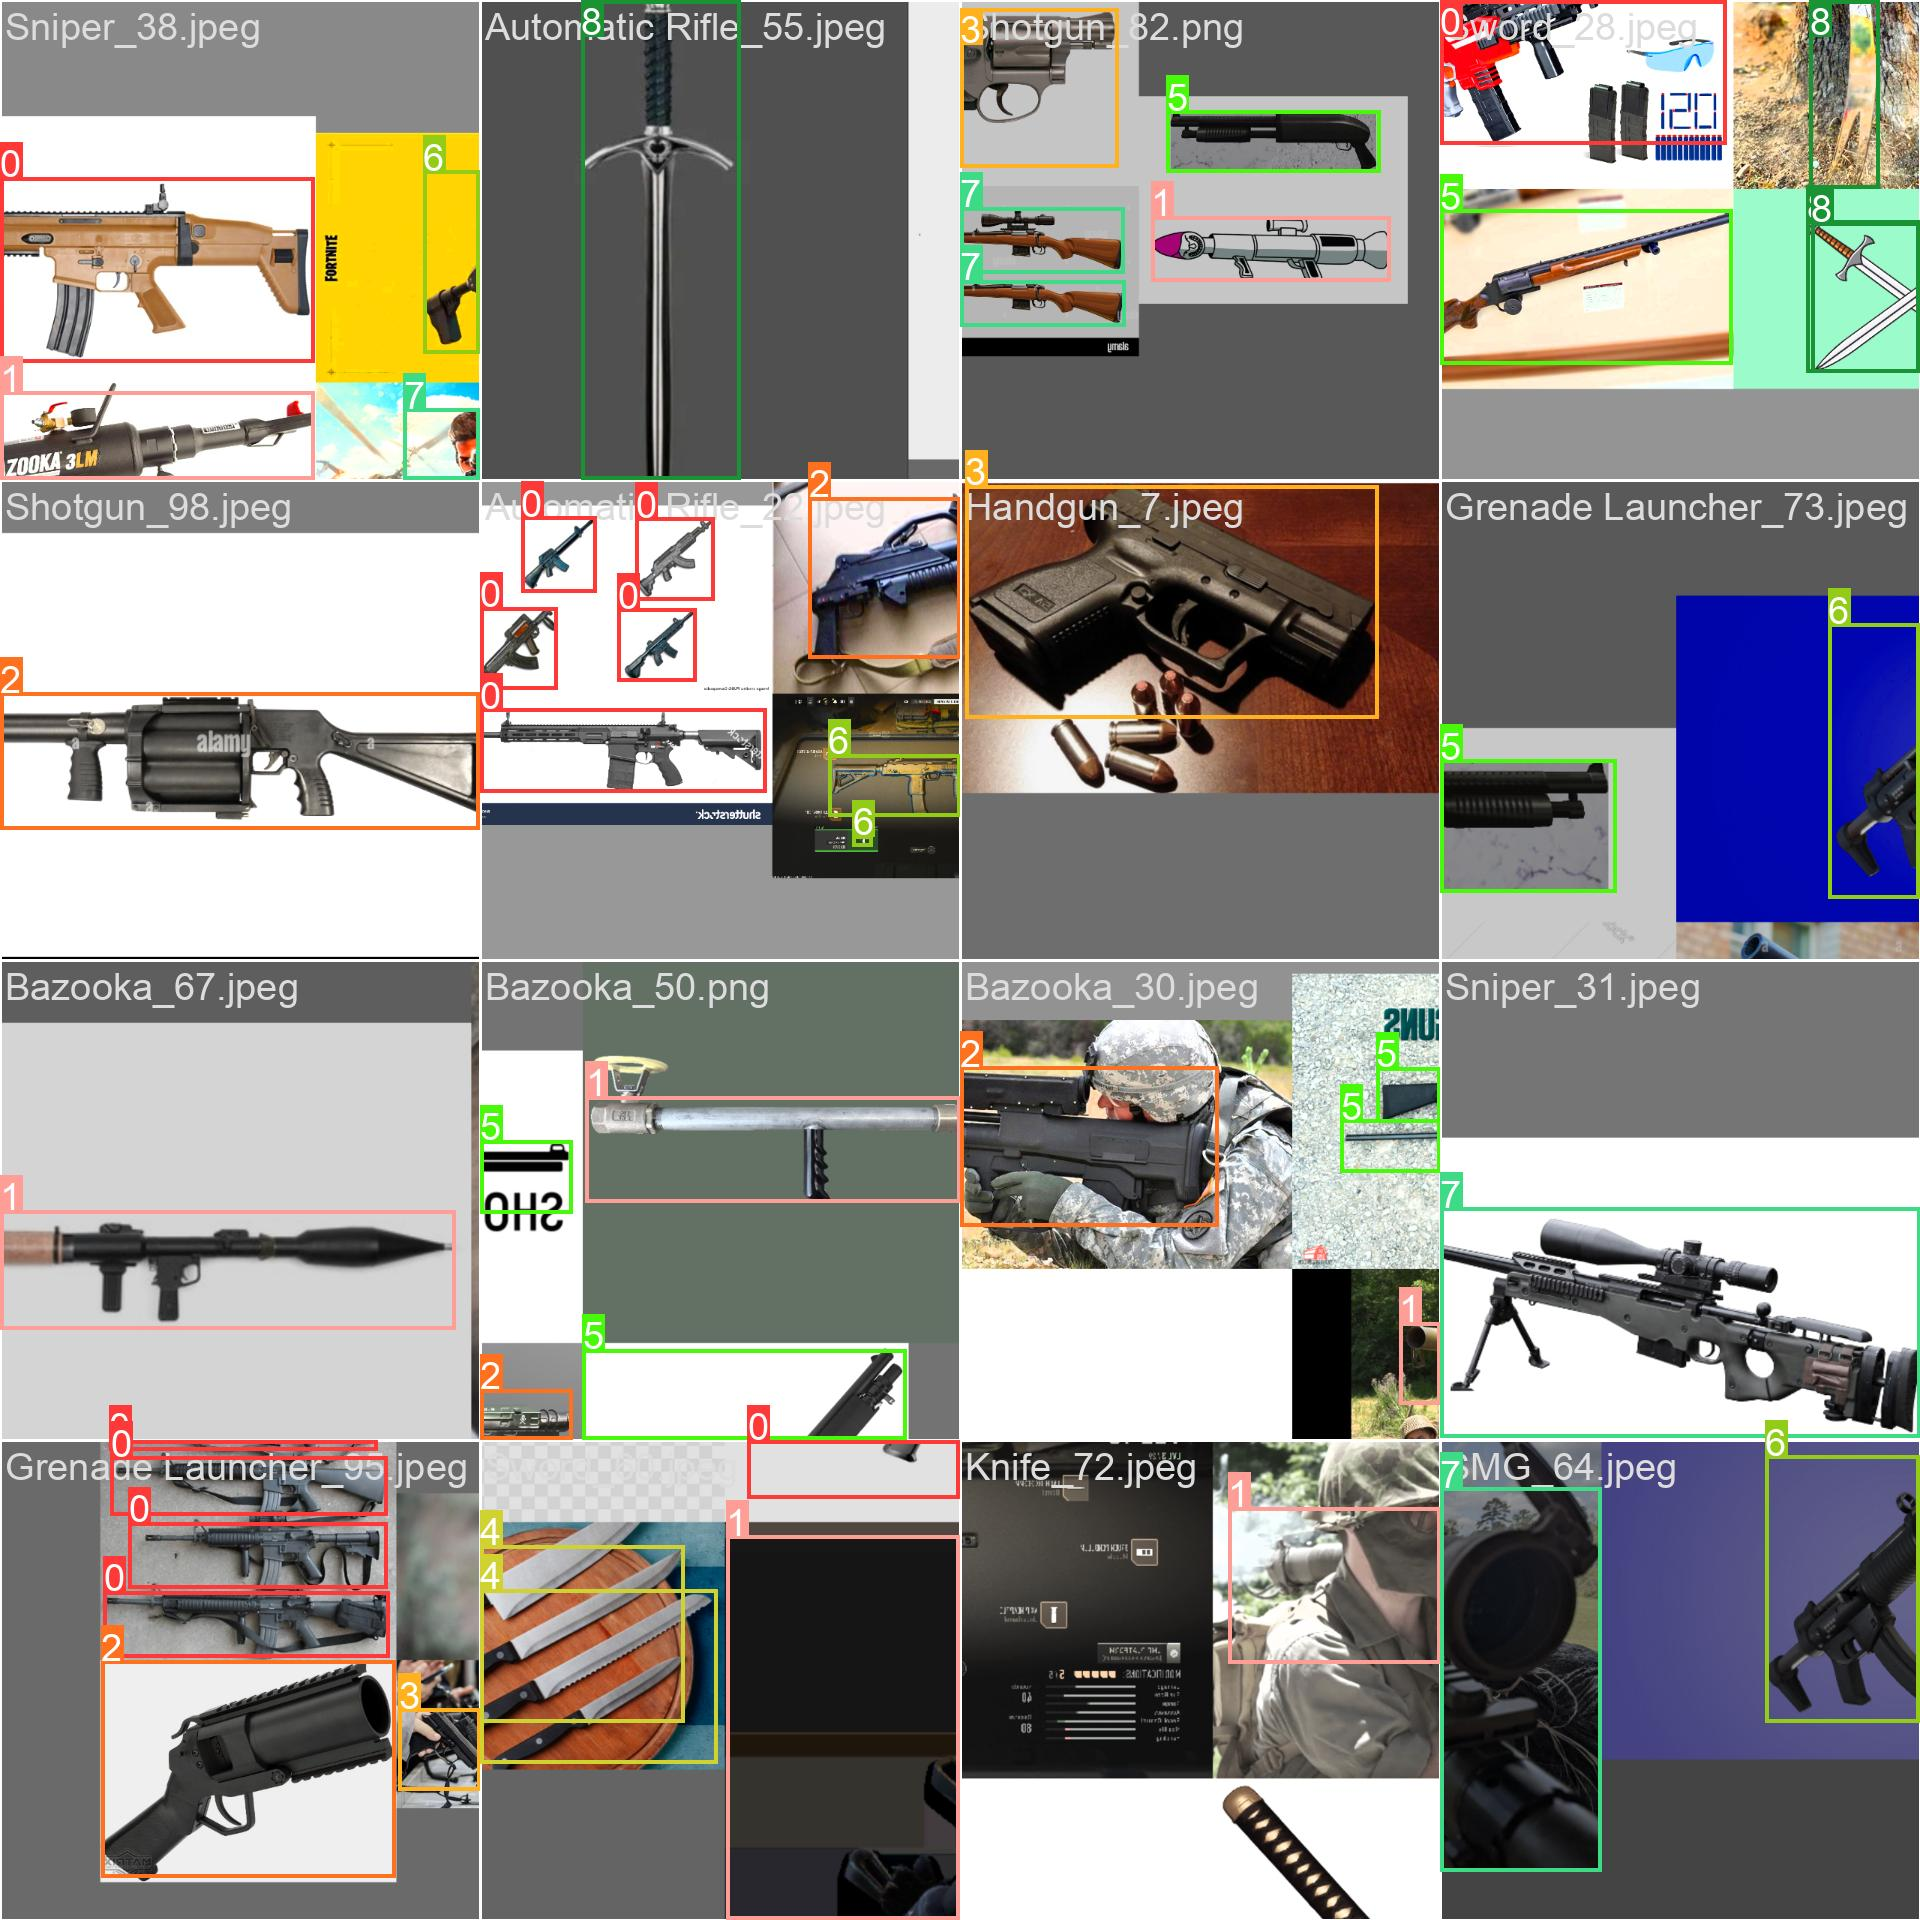

### train_results/PR_curve.png

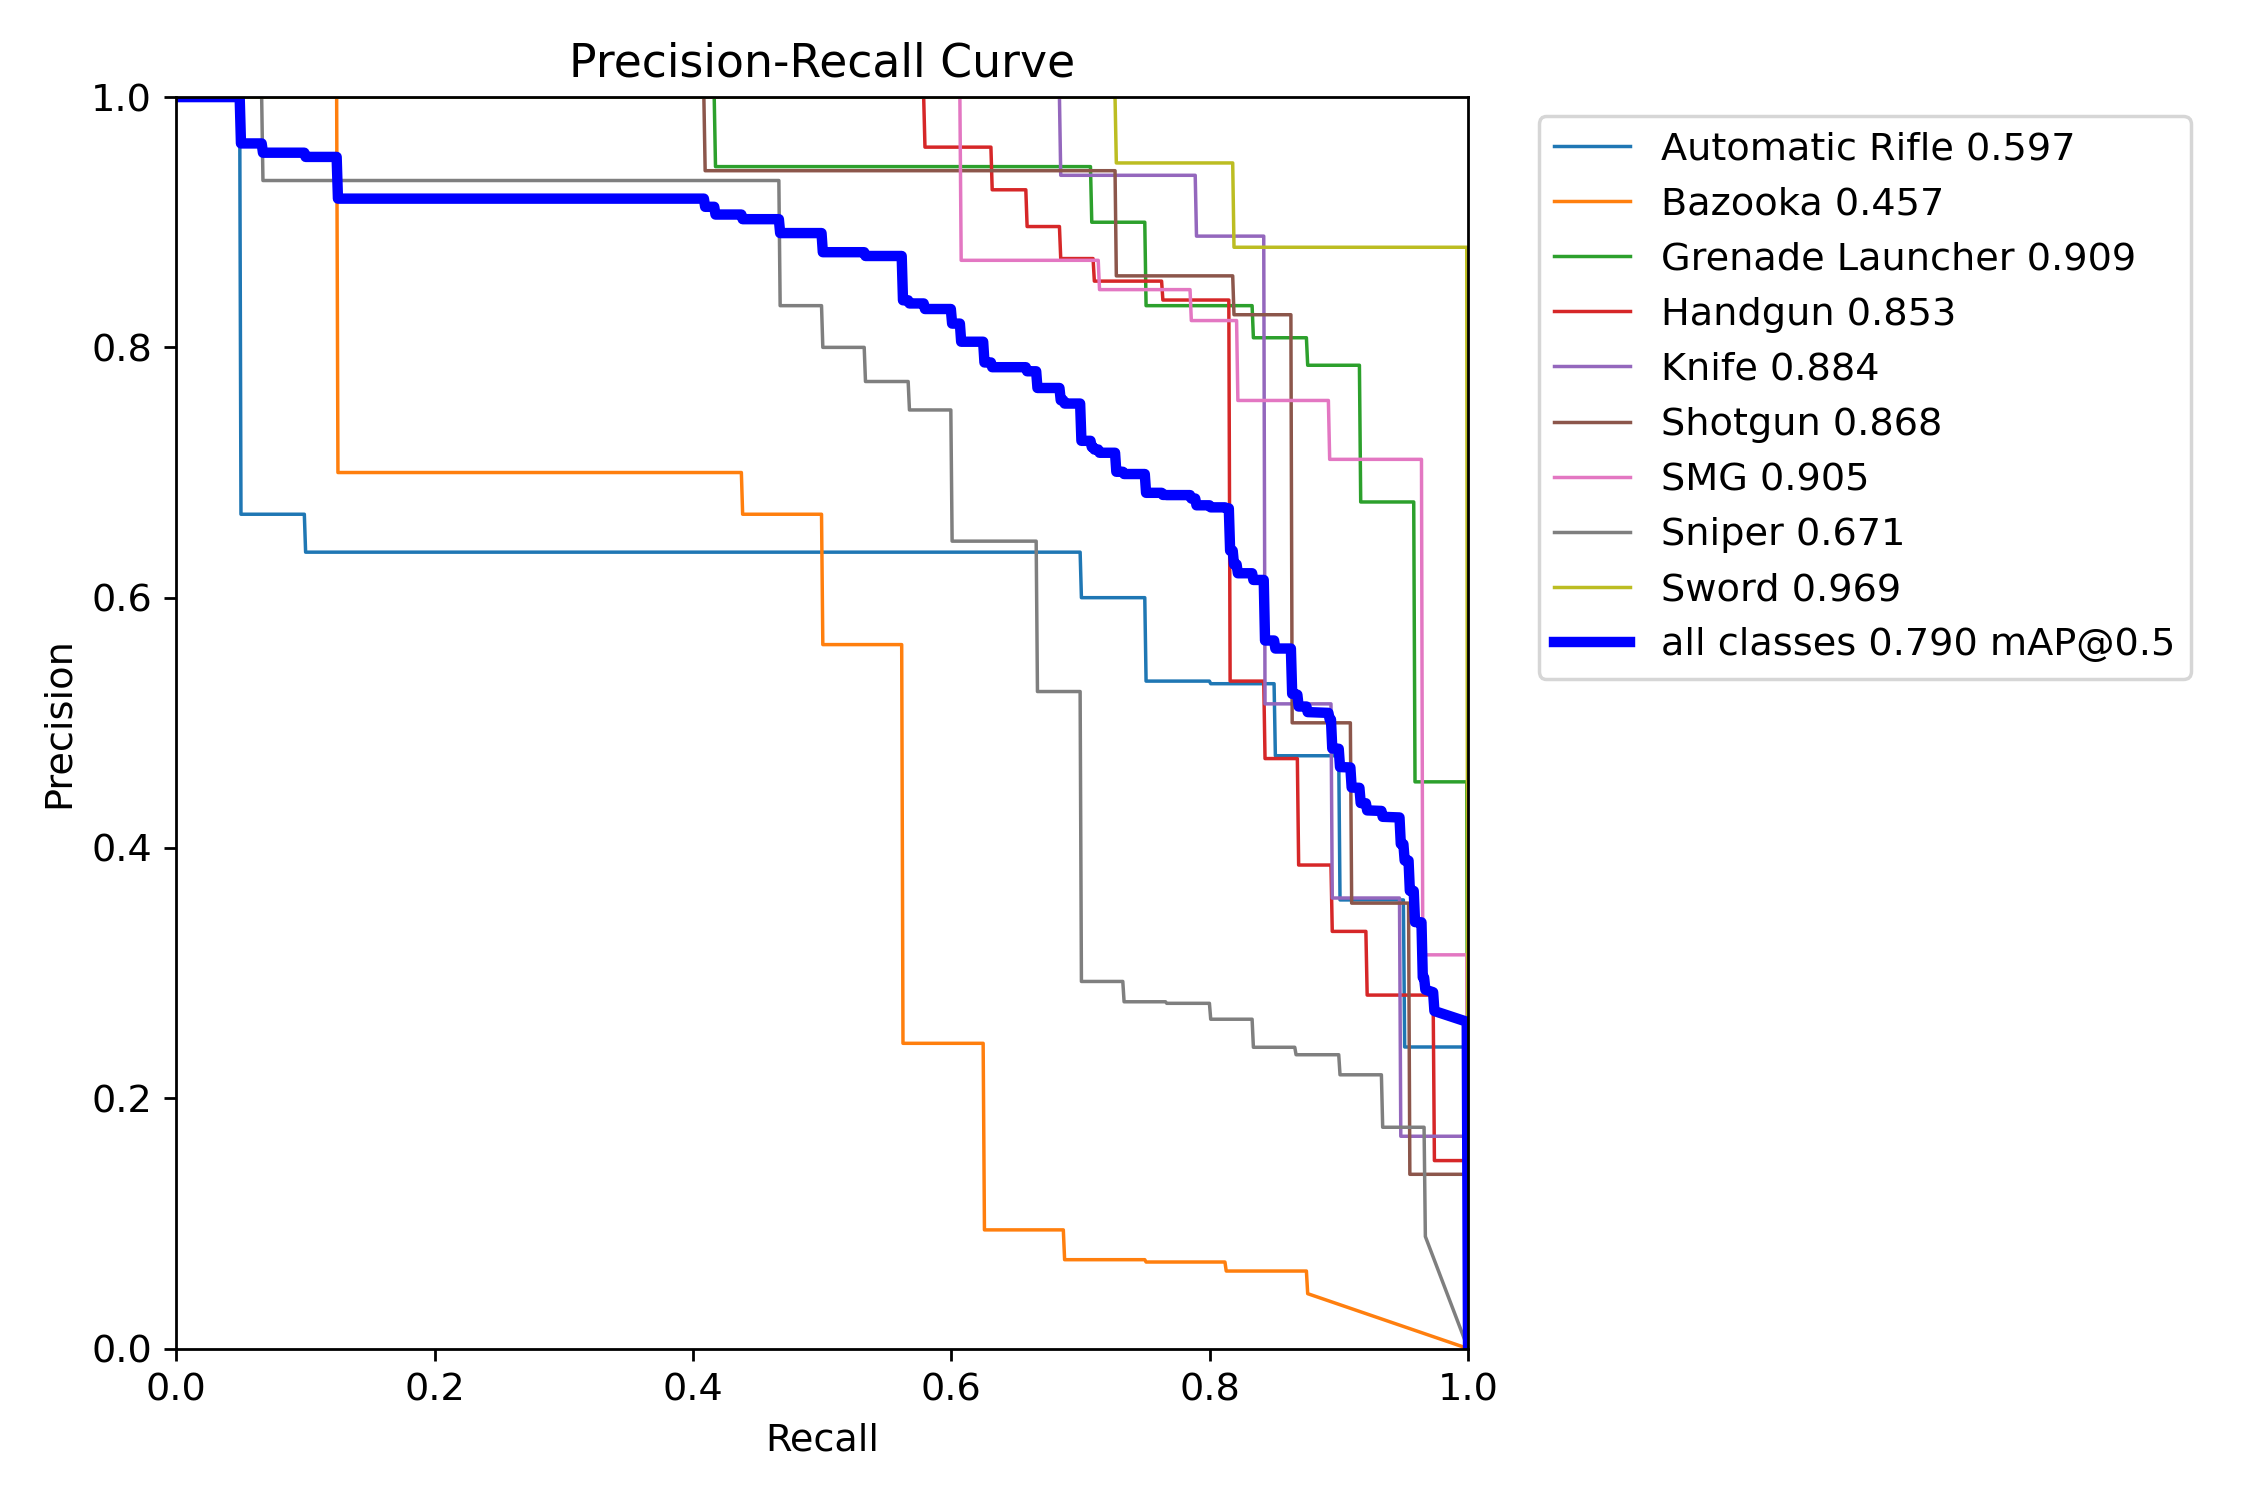

### train_results/F1_curve.png

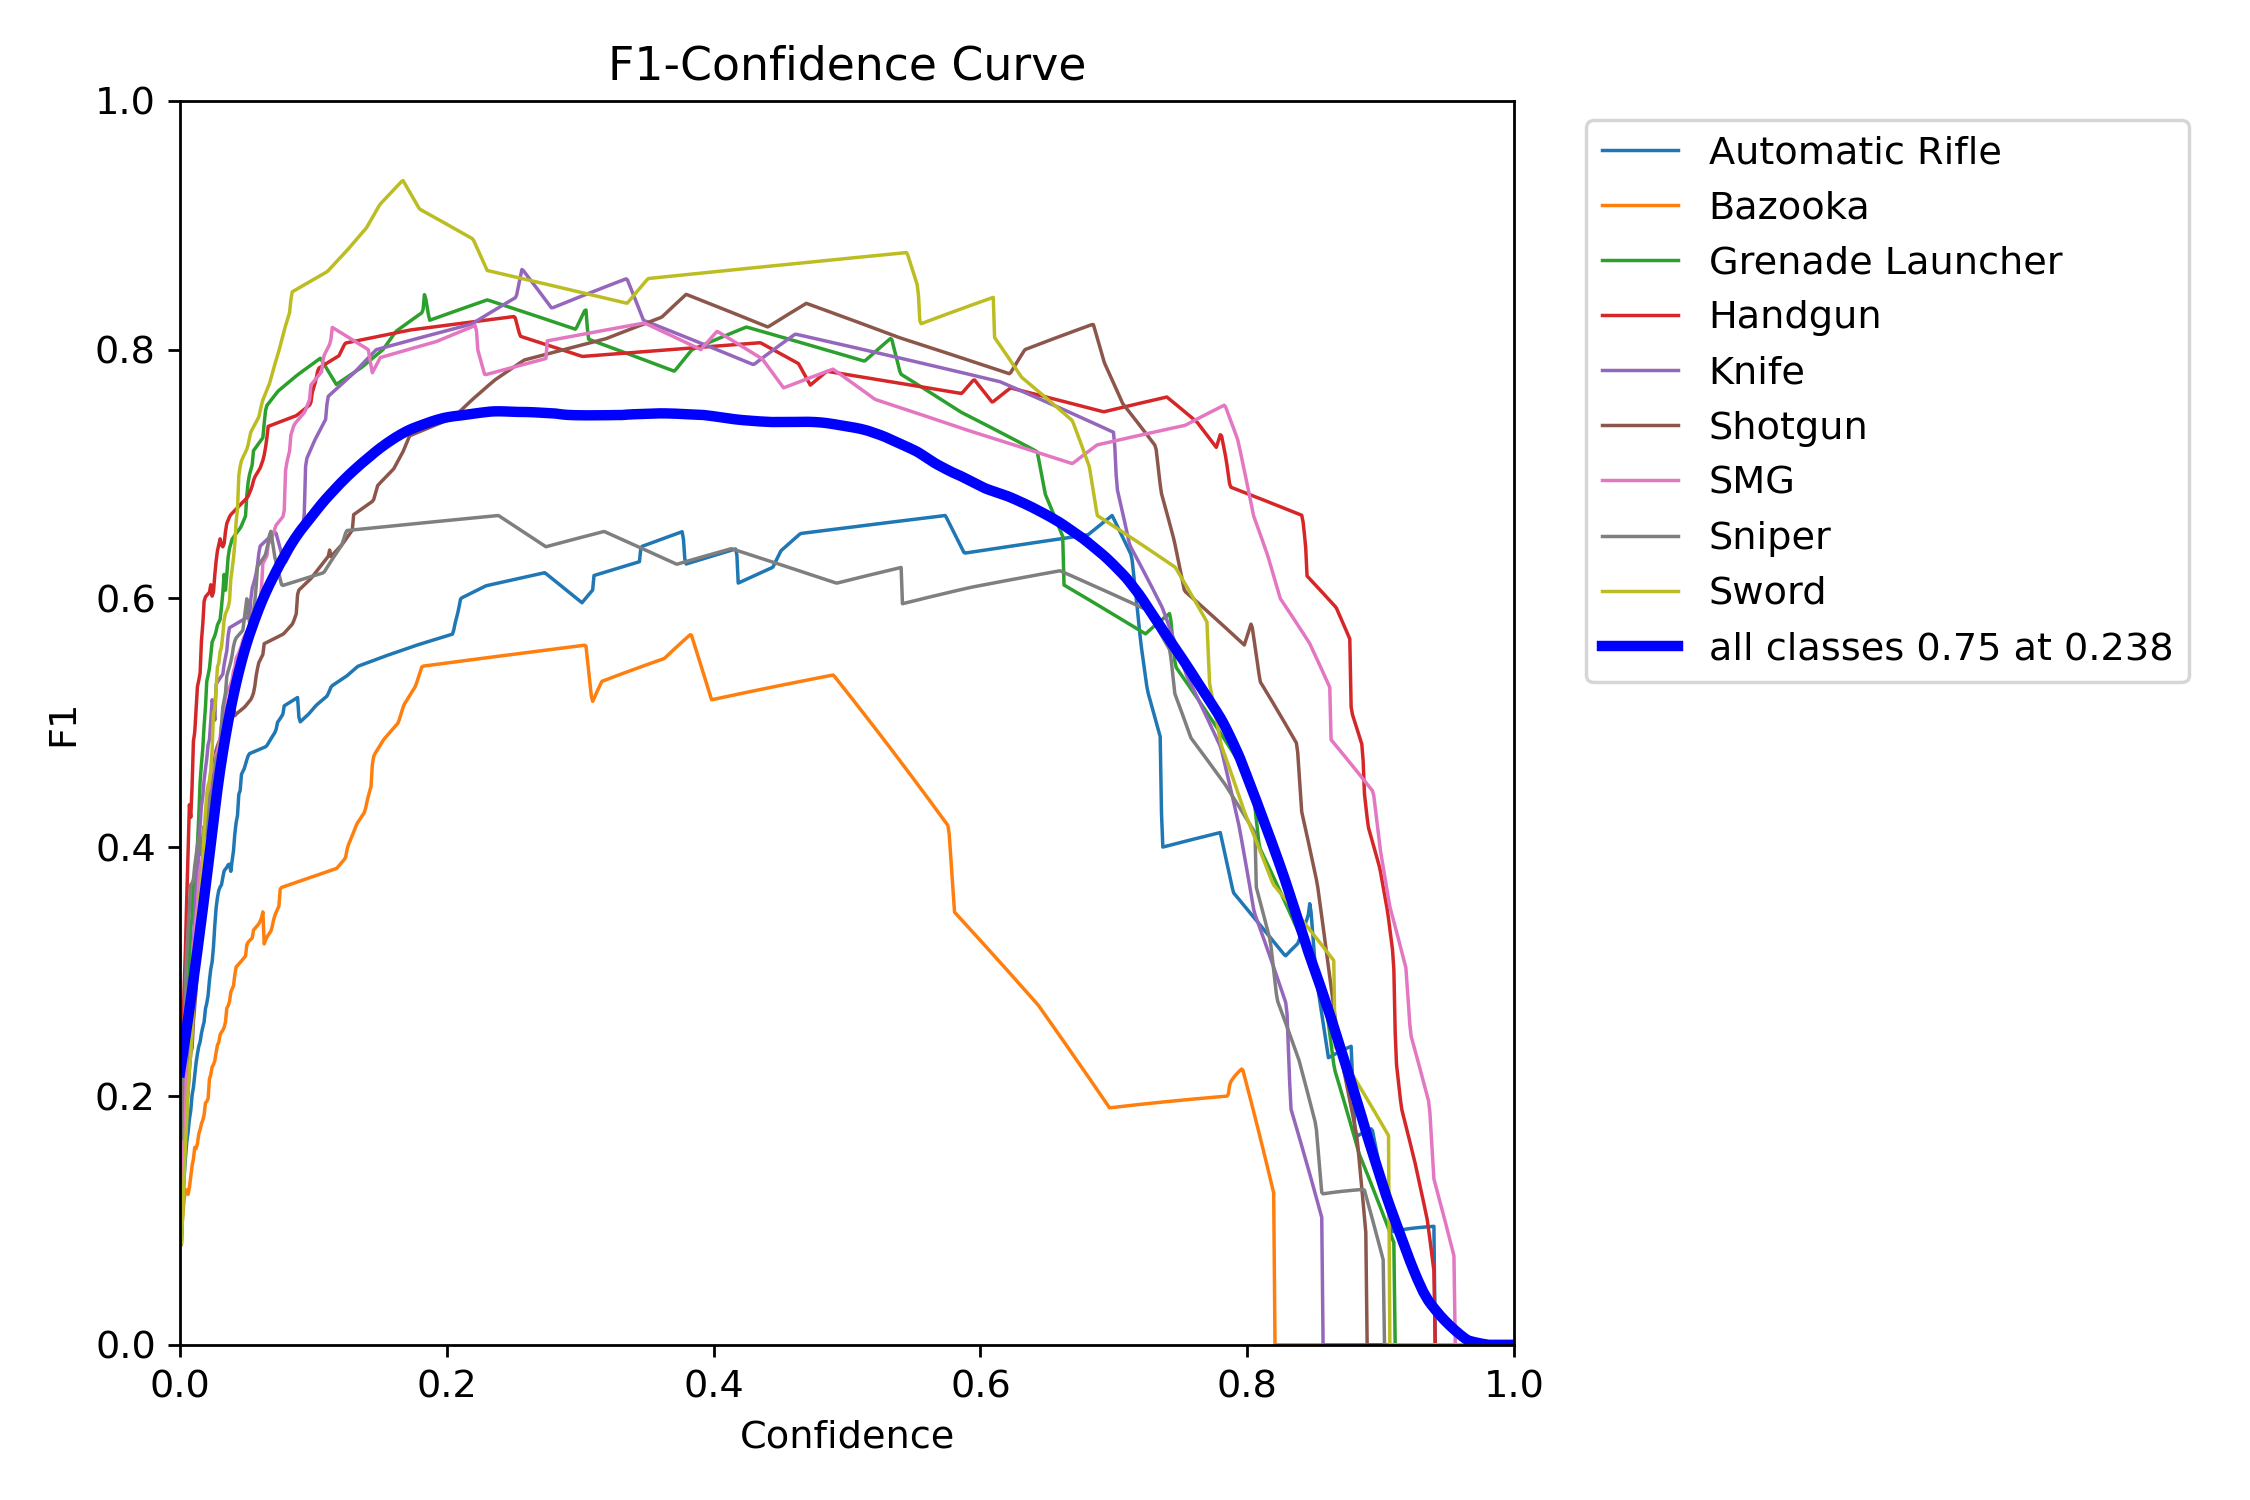

### train_results/val_batch1_pred.jpg

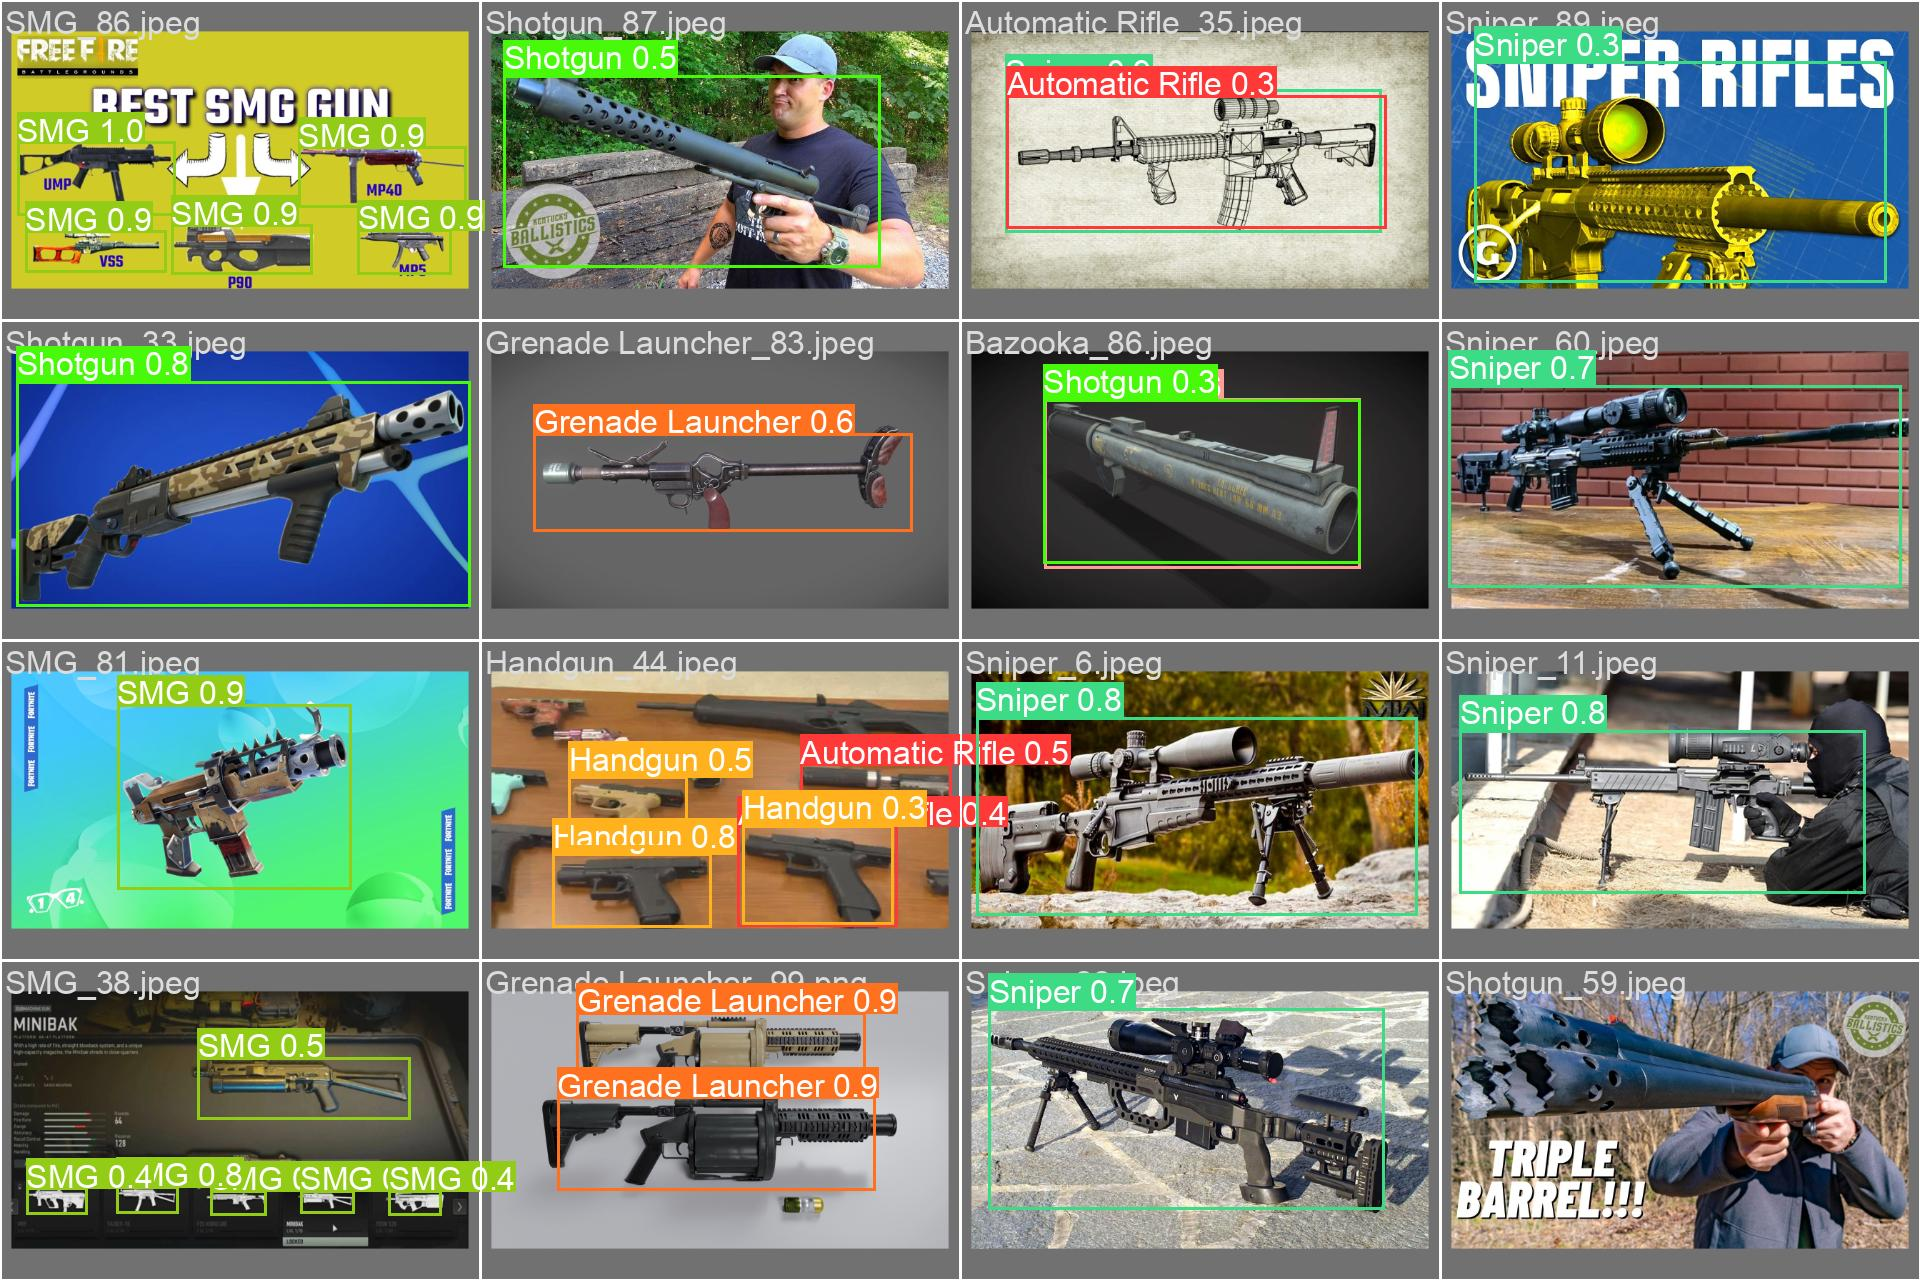

### train_results/P_curve.png

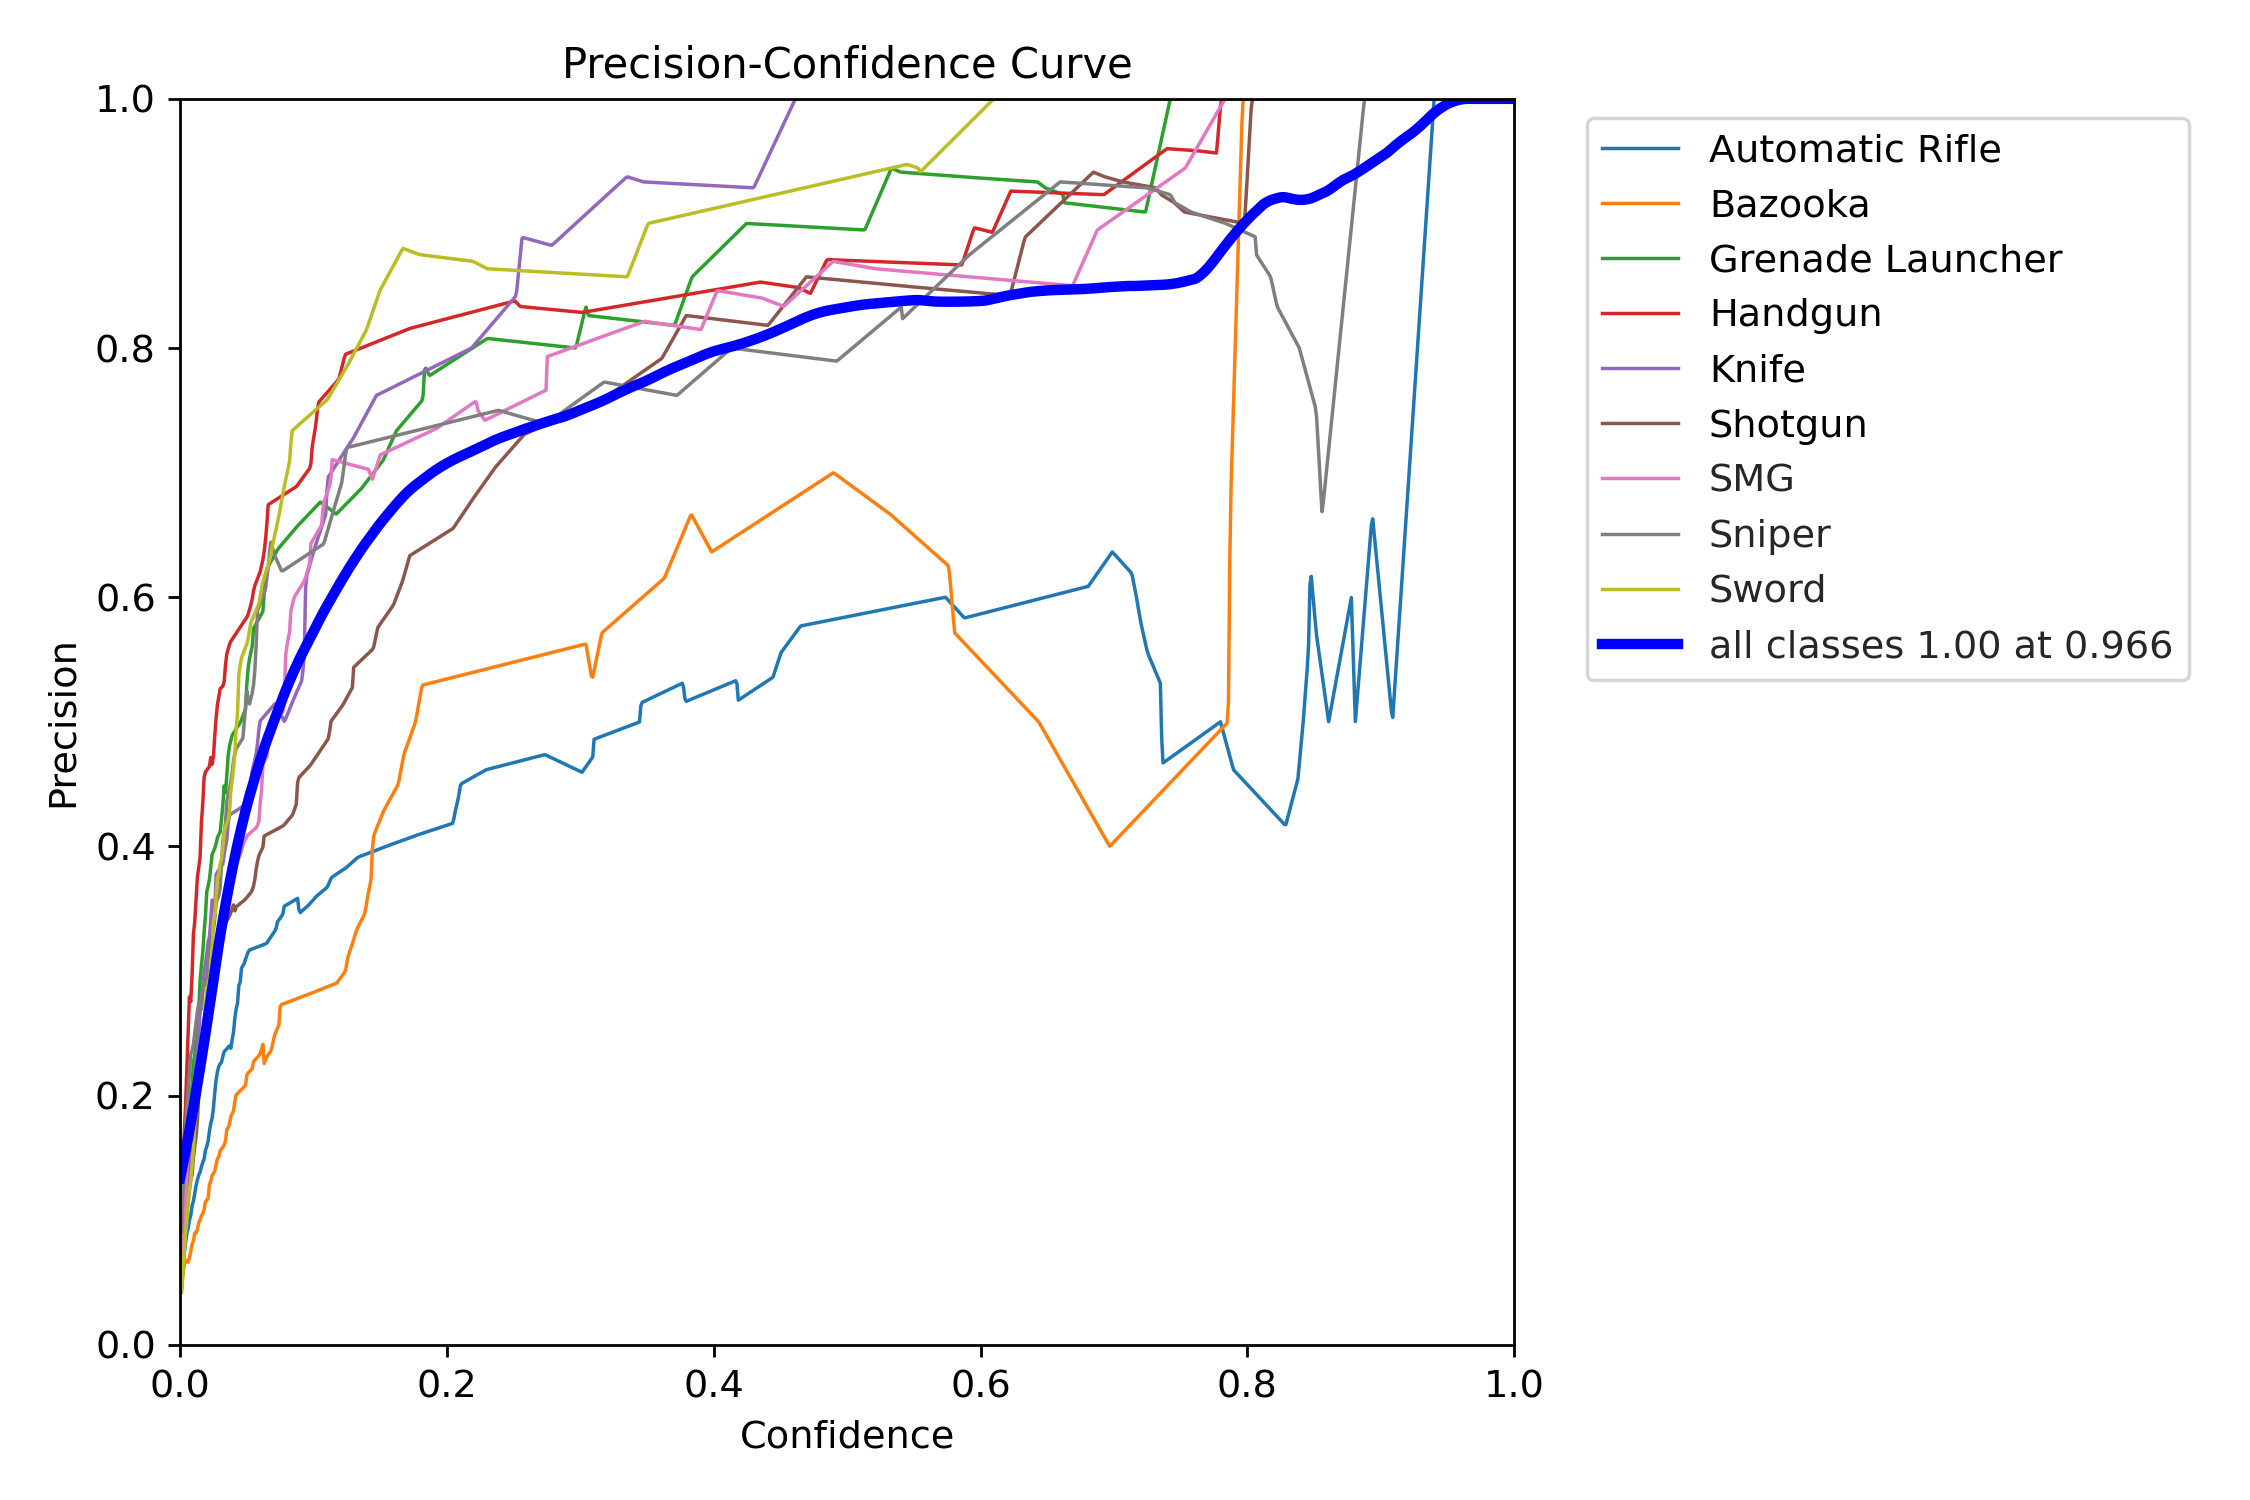

### train_results/val_batch2_labels.jpg

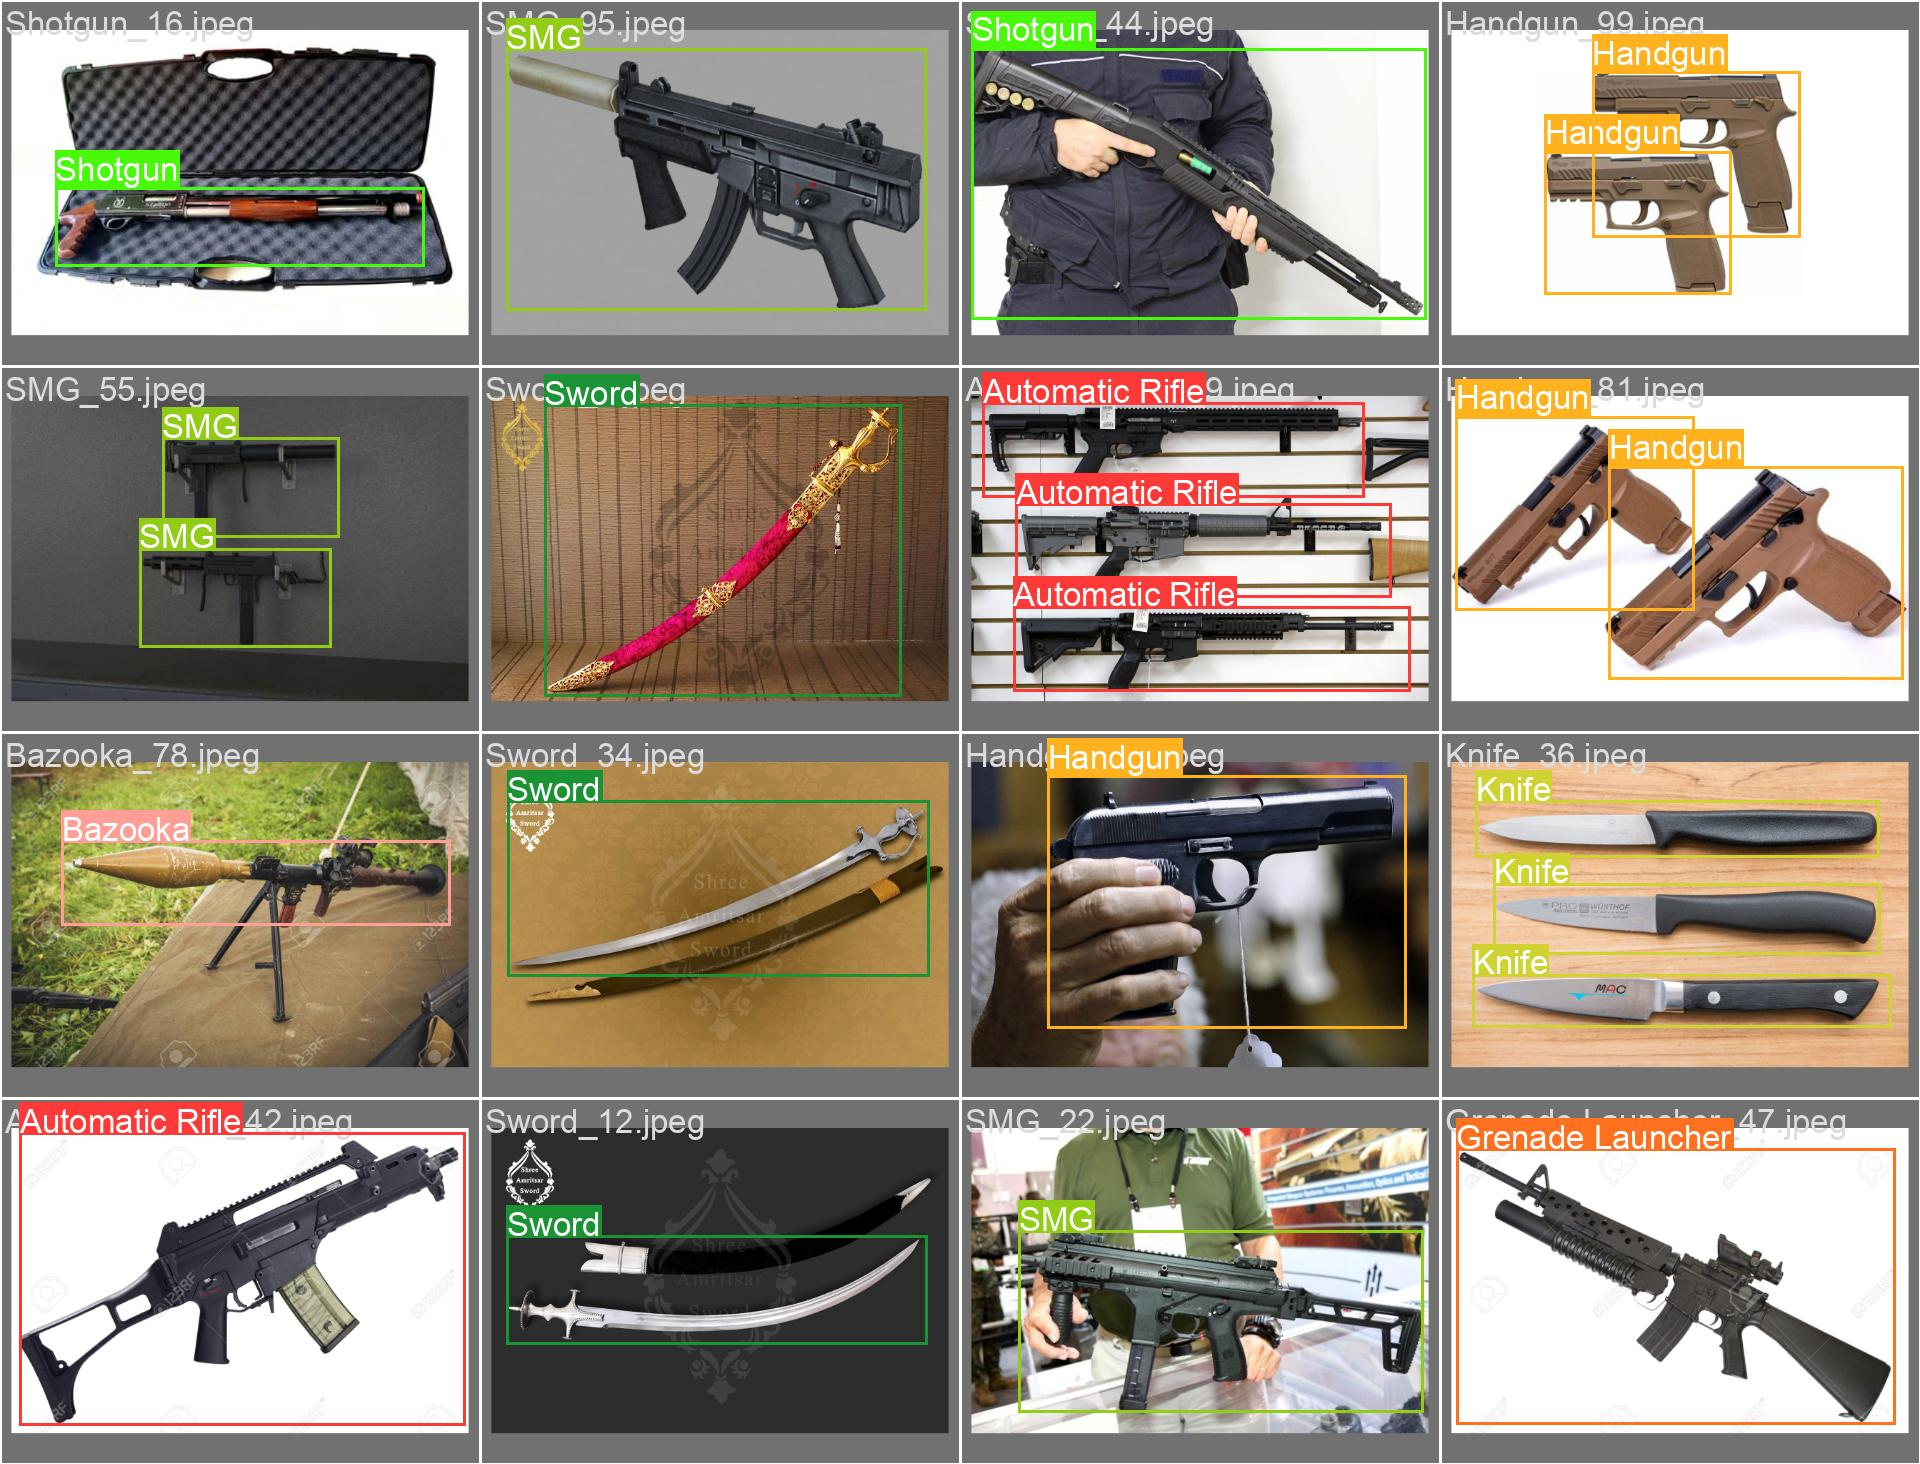

### train_results/val_batch1_labels.jpg

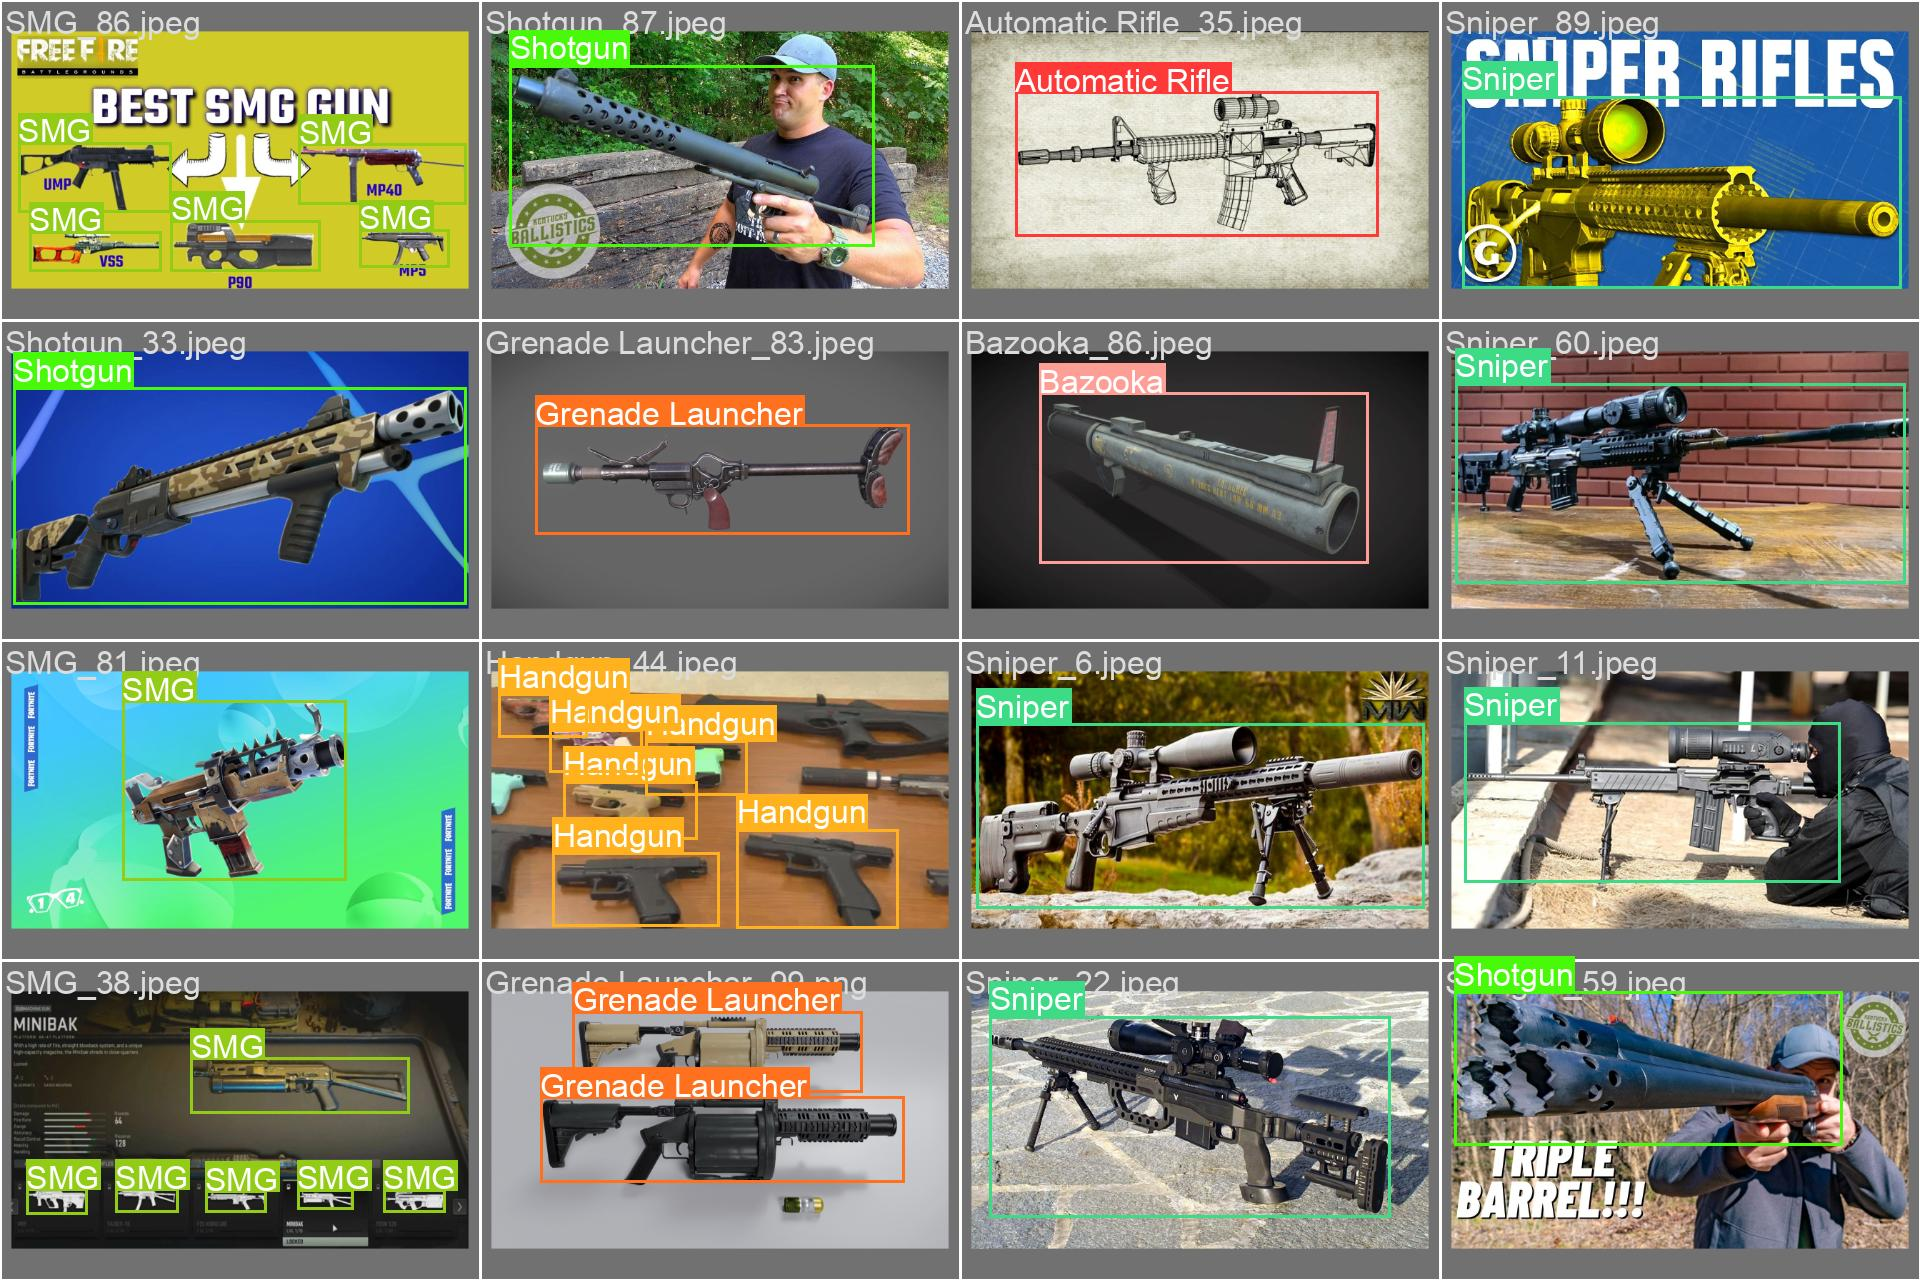

❗ No training data found for plotting curves
📊 Plotting evaluation metrics...


<ipython-input-3-0e913718ff70>:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(final_metrics.keys()), y=list(final_metrics.values()), palette='viridis')


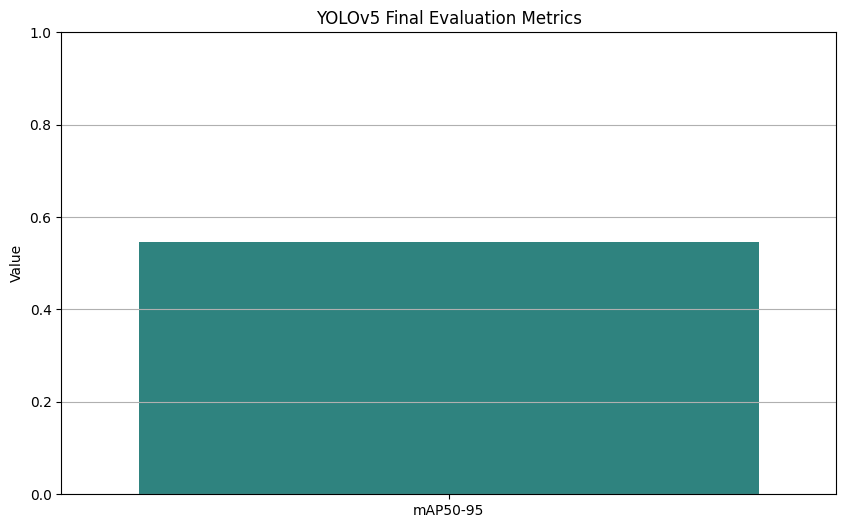

👁️ Displaying detection visualizations...
❗ No detection visualizations found
📋 Metrics Summary
❓ metrics_summary.txt not found

Metrics from evaluation results:
     metrics/precision: 0.7644
        metrics/recall: 0.7729
       metrics/mAP_0.5: 0.7808
  metrics/mAP_0.5:0.95: 0.5460


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, Markdown
import glob

class YOLOv5WeaponResultsVisualizer:
    def __init__(self, results_dir):
        self.results_dir = results_dir
        self.train_results_dir = os.path.join(results_dir, 'train_results')
        self.eval_results_dir = os.path.join(results_dir, 'eval_results')
        self.visualizations_dir = os.path.join(results_dir, 'visualizations')

        # Initialize loss and metrics DataFrames
        self.loss_df = None
        self.metrics_df = None

        # Print directory structure to help with debugging
        print(f"📂 Results directory structure:")
        self._print_directory_structure(self.results_dir)

    def _print_directory_structure(self, dir_path, indent=0):
        """Helper function to print directory structure"""
        if not os.path.exists(dir_path):
            print(f"{' ' * indent}❌ Directory does not exist: {dir_path}")
            return

        print(f"{' ' * indent}📁 {os.path.basename(dir_path)}/")
        indent += 2

        try:
            # Print first 10 items in directory
            items = os.listdir(dir_path)
            count = 0
            for item in sorted(items):
                item_path = os.path.join(dir_path, item)
                if os.path.isdir(item_path):
                    self._print_directory_structure(item_path, indent)
                else:
                    print(f"{' ' * indent}📄 {item}")
                count += 1
                if count >= 10 and len(items) > 10:
                    print(f"{' ' * indent}... ({len(items) - 10} more items)")
                    break
        except Exception as e:
            print(f"{' ' * indent}❌ Error reading directory: {e}")

    def find_results_files(self):
        """Find all results files in the YOLOv5 directory structure"""
        print("🔍 Finding YOLOv5 result files...")

        # Results files patterns to look for
        patterns = {
            'train_csv': os.path.join(self.train_results_dir, '*.csv'),
            'train_plots': os.path.join(self.train_results_dir, '*.png'),
            'weights': os.path.join(self.train_results_dir, 'weights', '*.pt'),
            'eval_csv': os.path.join(self.eval_results_dir, '*.csv'),
            'visualizations': os.path.join(self.visualizations_dir, '*.jpg')
        }

        found_files = {}
        for name, pattern in patterns.items():
            files = glob.glob(pattern)
            found_files[name] = files
            print(f"Found {len(files)} {name} files")

        # Set specific files for easier access
        if found_files['train_csv']:
            for file in found_files['train_csv']:
                if 'results' in file.lower():
                    try:
                        self.train_df = pd.read_csv(file)
                        print(f"📊 Loaded training results from {os.path.basename(file)}")
                    except Exception as e:
                        print(f"❌ Error loading {file}: {e}")

        if found_files['eval_csv']:
            for file in found_files['eval_csv']:
                if 'results' in file.lower():
                    try:
                        self.metrics_df = pd.read_csv(file)
                        print(f"📊 Loaded evaluation metrics from {os.path.basename(file)}")
                    except Exception as e:
                        print(f"❌ Error loading {file}: {e}")

        return found_files

    def display_train_plots(self):
        """Display all training plots generated by YOLOv5"""
        print("📊 Displaying training plots...")

        # Expected plot names in YOLOv5
        expected_plots = [
            'results.png',            # Main results plot
            'confusion_matrix.png',   # Confusion matrix
            'labels.jpg',             # Label analysis
            'labels_correlogram.jpg'  # Label correlation
        ]

        for plot_name in expected_plots:
            plot_path = os.path.join(self.train_results_dir, plot_name)
            if os.path.exists(plot_path):
                display(Markdown(f"### {plot_name}"))
                display(Image(filename=plot_path))
            else:
                print(f"❓ Plot not found: {plot_name}")

        # Look for any other plots
        for root, _, files in os.walk(self.train_results_dir):
            for file in files:
                if file.endswith(('.png', '.jpg')) and file not in expected_plots:
                    file_path = os.path.join(root, file)
                    display(Markdown(f"### {os.path.relpath(file_path, self.results_dir)}"))
                    display(Image(filename=file_path))

    def display_visualizations(self, max_images=5):
        """Display detection visualization results"""
        print("👁️ Displaying detection visualizations...")

        visualization_paths = []

        # Check main visualization directory
        if os.path.exists(self.visualizations_dir):
            for file in os.listdir(self.visualizations_dir):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    visualization_paths.append(os.path.join(self.visualizations_dir, file))

        # If no visualizations found in expected directory, search deeper
        if not visualization_paths:
            for root, _, files in os.walk(self.results_dir):
                for file in files:
                    if file.startswith('detection_') and file.endswith(('.jpg', '.jpeg', '.png')):
                        visualization_paths.append(os.path.join(root, file))

        # Display visualizations
        if visualization_paths:
            for i, img_path in enumerate(visualization_paths[:max_images]):
                display(Markdown(f"### Detection {i+1}: {os.path.basename(img_path)}"))
                display(Image(filename=img_path))

            if len(visualization_paths) > max_images:
                print(f"... and {len(visualization_paths) - max_images} more visualizations")
        else:
            print("❗ No detection visualizations found")

    def load_and_display_csvs(self):
        """Load and display all CSV files in results directories"""
        print("📈 Loading and displaying all CSV files...")

        csv_paths = []

        # Look for CSVs in both train and eval directories
        for root_dir in [self.train_results_dir, self.eval_results_dir]:
            if os.path.exists(root_dir):
                for root, _, files in os.walk(root_dir):
                    for file in files:
                        if file.endswith('.csv'):
                            csv_paths.append(os.path.join(root, file))

        for file_path in csv_paths:
            try:
                df = pd.read_csv(file_path)
                display(Markdown(f"### `{os.path.relpath(file_path, self.results_dir)}` (Preview)"))
                display(df.head())  # Show first 5 rows

                # Store dataframes for plotting
                if 'epoch' in df.columns and any(col for col in df.columns if 'loss' in col.lower()):
                    self.loss_df = df

                # YOLOv5 metrics format
                if any(col for col in df.columns if 'map' in col.lower()):
                    self.metrics_df = df

            except Exception as e:
                print(f"❌ Could not read {file_path}: {e}")

    def plot_training_curves(self):
        """Plot training curves from YOLOv5 results.csv"""
        if self.loss_df is not None:
            print("📉 Plotting training curves...")

            # Determine what metrics are available
            metrics_to_plot = []
            for col in self.loss_df.columns:
                if col in ['box_loss', 'obj_loss', 'cls_loss'] or 'loss' in col.lower():
                    metrics_to_plot.append(col)

            if not metrics_to_plot:
                print("❗ No loss metrics found in training data")
                return

            # Plot training loss metrics
            plt.figure(figsize=(12, 6))
            x_col = 'epoch' if 'epoch' in self.loss_df.columns else self.loss_df.index

            for metric in metrics_to_plot:
                plt.plot(x_col, self.loss_df[metric], label=metric)

            plt.title('YOLOv5 Training Metrics')
            plt.xlabel('Epoch')
            plt.ylabel('Loss Value')
            plt.grid(True)
            plt.legend()
            plt.show()
        else:
            print("❗ No training data found for plotting curves")

    def plot_eval_metrics(self):
        """Plot final evaluation metrics from YOLOv5"""
        if self.metrics_df is not None:
            print("📊 Plotting evaluation metrics...")

            # YOLOv5 column naming convention
            yolov5_metrics = {
                'precision': ['precision', 'metrics/precision'],
                'recall': ['recall', 'metrics/recall'],
                'mAP50': ['mAP_0.5', 'metrics/mAP_0.5'],
                'mAP50-95': ['mAP_0.5:0.95', 'metrics/mAP_0.5:0.95']
            }

            final_metrics = {}

            # Extract metrics (taking the last row for final values)
            for metric_name, possible_cols in yolov5_metrics.items():
                for col in possible_cols:
                    if col in self.metrics_df.columns:
                        final_metrics[metric_name] = self.metrics_df[col].iloc[-1]
                        break

            if final_metrics:
                plt.figure(figsize=(10, 6))
                sns.barplot(x=list(final_metrics.keys()), y=list(final_metrics.values()), palette='viridis')
                plt.title('YOLOv5 Final Evaluation Metrics')
                plt.ylabel('Value')
                plt.ylim(0, 1)  # Metrics are usually between 0 and 1
                plt.grid(True, axis='y')
                plt.show()
            else:
                print("❗ No evaluation metrics found for plotting")
        else:
            print("❗ No evaluation data found for plotting metrics")

    def display_metrics_summary(self):
        """Display a summary of all metrics"""
        print("📋 Metrics Summary")

        metrics_file = os.path.join(self.results_dir, 'metrics_summary.txt')
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                content = f.read()
                display(Markdown(f"```\n{content}\n```"))
        else:
            print("❓ metrics_summary.txt not found")

            # Try to construct summary from available data
            if self.metrics_df is not None:
                print("\nMetrics from evaluation results:")
                for col in self.metrics_df.columns:
                    if any(keyword in col.lower() for keyword in ['map', 'precision', 'recall']):
                        value = self.metrics_df[col].iloc[-1]
                        print(f"  {col}: {value:.4f}")

# Main execution
if __name__ == "__main__":
    # Path to results directory (adjust this to your actual results path)
    results_dir = './results_yolov5'

    # Create visualizer
    visualizer = YOLOv5WeaponResultsVisualizer(results_dir)

    # Find and analyze results
    visualizer.find_results_files()
    visualizer.load_and_display_csvs()
    visualizer.display_train_plots()
    visualizer.plot_training_curves()
    visualizer.plot_eval_metrics()
    visualizer.display_visualizations()
    visualizer.display_metrics_summary()

In [ ]:
pip install yolov5

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-11 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7034398 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


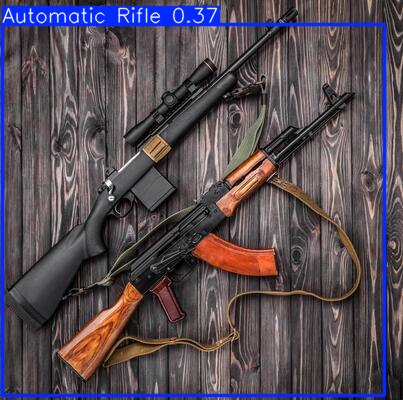

In [7]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Load YOLOv5 model (ensure it's a YOLOv5 model)
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/Weapon-Detection/results_yolov5/train_results/weights/best.pt')  # Replace with your YOLOv5 model path

# Image path
image_path = '/content/Weapon-Detection/Weapon Project/weapon_detection/test/test/weapon2.jpg'  # Replace with your test image path

# Run inference
results = model(image_path)

# Display the image with bounding boxes
results.show()  # This will automatically plot the image with bounding boxes